In [ ]:
%cd /mnt/hdd/jeff/mdgen-working
import sys
sys.path.append("bin/src")
%load_ext autoreload
%autoreload 2

# MD preprocess

## dcd PBC

In [ ]:
import MDAnalysis as mda
pdb = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-zh/raw-data/collagen_wt.pdb'
dcd = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-zh/raw-data/collagen_wt_nvt.dcd'
u = mda.Universe(pdb, dcd)
u.trajectory[0]               # 讀第一幀
print(u.trajectory.ts.dimensions)   # [Lx, Ly, Lz, alpha, beta, gamma]


## dcd to xtc

In [19]:
import MDAnalysis as mda
from typing import List
def dcds_to_xtc(pdb, dcds, out_xtc):

    u = mda.Universe(pdb, dcds)

    # Write concatenated XTC
    with mda.Writer(out_xtc, u.atoms.n_atoms) as W:
        for ts in u.trajectory:
            W.write(u.atoms)


### psf remove tip3 and cla

### psf dcd->xtc

In [15]:
import MDAnalysis as mda
from MDAnalysis.transformations import unwrap, center_in_box
import os

def psfdcd_to_xtc(psf_path, dcd_paths, output_xtc):
    """
    將 DCD 轉換為 XTC，並修正 PBC 造成的斷裂問題。
    """
    u = mda.Universe(psf_path, dcd_paths)
    protein = u.select_atoms("protein")
    with mda.Writer(output_xtc, protein.n_atoms) as W:
        for ts in u.trajectory:
            W.write(protein)

In [ ]:
psf = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/protein_only.psf'
dcd1 = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/wrapped.dcd'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/wrap.xtc'
psfdcd_to_xtc(psf, dcd1, xtc)

## align on pdb

In [12]:
def align_xtc_to_pdb_frame0(pdb, xtc, out_xtc,
                           select_align="protein and name CA",
                           in_memory=False,
                           verbose=True):
    """
    Align trajectory (xtc) to reference structure (pdb, frame0), then write aligned xtc.

    inputs
      pdb: reference structure file (PDB)
      xtc: trajectory file (XTC)
      out_xtc: output aligned trajectory (XTC)
      select_align: atom selection used for alignment (MDAnalysis selection string)
      in_memory: if True, keep aligned coords in memory (faster for small traj; more RAM)
    """

    import os
    import MDAnalysis as mda
    from MDAnalysis.analysis import align

    if not os.path.isfile(pdb):
        raise FileNotFoundError(pdb)
    if not os.path.isfile(xtc):
        raise FileNotFoundError(xtc)

    # mobile trajectory
    u = mda.Universe(pdb, xtc)

    # reference – pdb only, frame0
    ref = mda.Universe(pdb)

    mob_sel = u.select_atoms(select_align)
    ref_sel = ref.select_atoms(select_align)

    if mob_sel.n_atoms == 0:
        raise ValueError(f"select_align empty in mobile: '{select_align}'")
    if ref_sel.n_atoms == 0:
        raise ValueError(f"select_align empty in reference: '{select_align}'")
    if mob_sel.n_atoms != ref_sel.n_atoms:
        raise ValueError(
            f"align selection mismatch: mobile={mob_sel.n_atoms}, ref={ref_sel.n_atoms} "
            f"for '{select_align}'"
        )

    # ensure output dir exists
    out_dir = os.path.dirname(os.path.abspath(out_xtc))
    if out_dir and (not os.path.isdir(out_dir)):
        os.makedirs(out_dir, exist_ok=True)

    # align and write
    al = align.AlignTraj(
        u, ref,
        select=select_align,
        in_memory=in_memory,
        filename=out_xtc
    )
    al.run()

    if verbose:
        print(f"[OK] aligned xtc written: {out_xtc}")

In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc_in = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
xtc_out = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water-align.xtc'
align_xtc_to_pdb_frame0(pdb, xtc_in, xtc_out)

## remove water su

In [6]:
def strip_water_and_ions_save(
    pdb_in, xtc_in, pdb_out, xtc_out,
    water_sel="resname TIP3 TIP3M SOL HOH WAT",
    ion_sel="resname CLA CL NA K CA MG ZN POT SOD"
):
    import MDAnalysis as mda
    from MDAnalysis.coordinates.XTC import XTCWriter

    u = mda.Universe(pdb_in, xtc_in)

    # 去掉水 + 離子/鹽類（包含你說的 SU 那種）
    keep = u.select_atoms(f"not (({water_sel}) or ({ion_sel}))")

    if len(keep) == 0:
        raise ValueError("Selection resulted in 0 atoms. Check your water/ion resnames.")

    # 寫出 PDB（第0幀）
    keep.write(pdb_out)

    # 寫出 XTC（逐幀）
    with XTCWriter(xtc_out, n_atoms=len(keep)) as W:
        for ts in u.trajectory:
            W.write(keep)



In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/homo_neutral.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/29_ALA_1_0202.xtc'
pdb_out = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/pdbxtc/29_ALA-water.pdb'
xtc_out = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/pdbxtc/29_ALA-water.xtc'
strip_water_and_ions_save(pdb,xtc,pdb_out,xtc_out)

## pdb xtc format

In [ ]:
def normalize_pdb_xtc(in_pdb, in_xtc, out_pdb, out_xtc,
                      chain_from="segid_lastchar",   # "segid_lastchar" or "segment_index"
                      renumber_resseq=False,
                      start_resseq=1,
                      stride=1):
    """
    將你這種非標準 PDB（尾巴有 0A/0B 當 segid）轉成「標準 PDB」：
      - chainID 寫入標準 PDB 第22欄
      - resSeq 寫入第23-26欄（可選擇是否每條鏈重編）
    同時重寫 XTC（座標不變，只是換成新 topology 相容的輸出）。

    依賴：MDAnalysis
    """
    import numpy as np
    import MDAnalysis as mda

    u = mda.Universe(in_pdb, in_xtc)

    # -------------------------
    # 1) 決定每個 segment 對應的 chainID
    # -------------------------
    segs = list(u.segments)
    if len(segs) == 0:
        raise ValueError("No segments found. Cannot assign chain IDs.")

    chain_pool = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789")
    if len(segs) > len(chain_pool):
        raise ValueError(f"Too many segments ({len(segs)}).")

    seg_to_chain = {}
    for i, seg in enumerate(segs):
        if chain_from == "segid_lastchar":
            sid = (seg.segid or "").strip()
            c = sid[-1] if len(sid) > 0 else chain_pool[i]
            seg_to_chain[seg.segid] = str(c)[0]
        elif chain_from == "segment_index":
            seg_to_chain[seg.segid] = chain_pool[i]
        else:
            raise ValueError("chain_from must be 'segid_lastchar' or 'segment_index'")

    # 建一個每個 atom 的 chainID array
    chain_arr = np.empty(u.atoms.n_atoms, dtype="<U1")
    for seg in u.segments:
        c = seg_to_chain.get(seg.segid, "A")
        chain_arr[seg.atoms.ix] = c

    # -------------------------
    # 2) 可選：每條鏈重編 resSeq（1,2,3...）
    #   不重編時：沿用 u.residues.resids（通常就是你看到的 999,1000...）
    # -------------------------
    # 我們最後寫 PDB 時會用 residue-level 的 resSeq，所以先準備一個 mapping
    # key: residue index (0..n_res-1) -> new resSeq int
    resseq_map = {}

    if renumber_resseq:
        # 依 chain 分組，以 residues 出現順序重編
        for c in sorted(set(chain_arr.tolist())):
            # 找這條 chain 的 atoms
            atom_idx = np.where(chain_arr == c)[0]
            ag = u.atoms[atom_idx]
            # residues 依拓撲順序
            new_id = start_resseq
            for r in ag.residues:
                resseq_map[r.ix] = int(new_id)
                new_id += 1
    else:
        # 沿用原始 resid（MDAnalysis 通常存在 r.resid）
        for r in u.residues:
            # r.resid 可能是 int（999,1000...）
            try:
                resseq_map[r.ix] = int(r.resid)
            except Exception:
                # fallback：用 r.ix + 1
                resseq_map[r.ix] = int(r.ix + 1)

    # -------------------------
    # 3) 手動寫標準 PDB（最穩）
    # -------------------------
    # 標準 PDB ATOM 欄位（簡化版，但 chainID/resSeq 位置正確）：
    # 1-6  "ATOM  "
    # 7-11 serial
    # 13-16 name
    # 17 altLoc
    # 18-20 resName
    # 22 chainID
    # 23-26 resSeq
    # 31-38 x
    # 39-46 y
    # 47-54 z
    # 55-60 occupancy
    # 61-66 tempFactor
    # 77-78 element
    # （其餘先不硬塞）
    u.trajectory[0]
    coords = u.atoms.positions  # Å in MDAnalysis

    def guess_element(atomname):
        # 粗略抓元素：去掉數字與空格，取前1-2字母
        s = "".join([ch for ch in atomname.strip() if ch.isalpha()])
        if len(s) == 0:
            return "  "
        if len(s) == 1:
            return f" {s.upper()}"
        # 常見兩字母元素：CL, NA, MG, FE...
        return s[:2].upper().rjust(2)

    with open(out_pdb, "w") as f:
        for i, atom in enumerate(u.atoms, start=1):
            name = atom.name
            resname = atom.resname
            chainID = chain_arr[atom.ix]
            resseq = resseq_map[atom.residue.ix]

            x, y, z = coords[atom.ix]  # Å
            occ = 1.00
            bfac = 0.00
            elem = guess_element(name)

            line = (
                f"ATOM  {i:5d} "
                f"{name:>4s}"
                f" "                 # altLoc
                f"{resname:>3s} "
                f"{chainID:1s}"
                f"{resseq:4d}    "
                f"{x:8.3f}{y:8.3f}{z:8.3f}"
                f"{occ:6.2f}{bfac:6.2f}          "
                f"{elem:>2s}\n"
            )
            f.write(line)
        f.write("END\n")

    # -------------------------
    # 4) 重寫 XTC（座標不變）
    # -------------------------
    with mda.coordinates.XTC.XTCWriter(out_xtc, n_atoms=u.atoms.n_atoms) as w:
        for ts in u.trajectory[::stride]:
            w.write(u.atoms)

    return out_pdb, out_xtc


# zh
pdb = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-zh/remove-water-su/collagen_wt.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-zh/remove-water-su/wt.xtc'
pdb_out = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-zh/normal-format/collagen_wt.pdb'
xtc_out = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-zh/normal-format/wt.xtc'

# wh
pdb = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-wh/water-su/wt.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-wh/water-su/wt.xtc'
pdb_out = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-wh/normal-form/wt.pdb'
xtc_out = '/mnt/hdd/jeff/dataset/output/mdgen-collagen-wh/normal-form/wt.xtc'
normalize_pdb_xtc(pdb,xtc,pdb_out,xtc_out)

## xtc [i,j] frame

In [ ]:
def slice_traj_frames(in_pdb, in_xtc,
                      out_pdb, out_xtc,
                      start, end,
                      stride=1):
    """
    Slice trajectory frames [start:end] with optional stride.

    Parameters
    ----------
    in_pdb : str
        Input topology PDB
    in_xtc : str
        Input trajectory XTC
    out_pdb : str
        Output PDB (single frame, first frame after slicing)
    out_xtc : str
        Output XTC (frames start:end with stride)
    start : int
        Start frame index (inclusive)
    end : int
        End frame index (exclusive)
    stride : int
        Stride for slicing (default = 1, keep all frames)
    """

    import mdtraj as md

    if stride <= 0:
        raise ValueError("stride must be a positive integer")

    # Load trajectory
    traj = md.load(in_xtc, top=in_pdb)

    if start < 0 or end > traj.n_frames or start >= end:
        raise ValueError(
            f"Invalid frame range: start={start}, end={end}, "
            f"valid: 0 <= start < end <= {traj.n_frames}"
        )

    # Slice with stride
    traj_slice = traj[start:end:stride]

    if traj_slice.n_frames == 0:
        raise ValueError("Slicing resulted in 0 frames; check start/end/stride")

    # Save outputs
    traj_slice[0].save_pdb(out_pdb)
    traj_slice.save_xtc(out_xtc)

    print(
        f"[OK] Saved frames {start}:{end} with stride={stride}\n"
        f"     PDB : {out_pdb}\n"
        f"     XTC : {out_xtc}\n"
        f"     n_frames = {traj_slice.n_frames}"
    )

    return traj_slice


# 5znj_A
in_pdb = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/5znj_A/5znj_A.pdb'
in_xtc = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/5znj_A/5znj_A_prod_R2_fit.xtc'
out_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-333cys/pdbxtc/5znj_A_0_300.pdb'
out_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-333cys/pdbxtc/5znj_A_0_300.xtc'      
slice_traj_frames(in_pdb,in_xtc,out_pdb,out_xtc, start=0, end=300)

## psf dcd->pdb, frame0

In [1]:
def write_frame_pdb_from_dcd_list(psf_path, dcd_list, frame_idx, out_pdb):
    """
    使用 MDAnalysis
    從 PSF + 多個 DCD（concatenated trajectory）
    讀取指定的「全域 frame」，輸出單一 PDB

    Parameters
    ----------
    psf_path : str
        PSF 檔案路徑
    dcd_list : list[str]
        DCD 檔案列表（會依序 concatenate）
    frame_idx : int
        全域 frame index（0-based）
    out_pdb : str
        輸出 PDB 檔名
    """
    import MDAnalysis as mda

    # 一個 Universe，吃多個 DCD（會自動串起來）
    u = mda.Universe(psf_path, dcd_list)

    n_frames = len(u.trajectory)
    if frame_idx >= n_frames:
        raise ValueError(
            f"frame_idx {frame_idx} 超出總 frame 數 {n_frames}"
        )

    # 跳到「concatenated 後」的 frame
    u.trajectory[frame_idx]

    # 輸出
    u.atoms.write(out_pdb)
    print(f"Wrote frame {frame_idx} to: {out_pdb}")


In [ ]:
psf = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/homo_neutral.psf'
dcd = ['/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt.dcd',
       '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt_0202.dcd',
       '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt_0203.dcd']
pdb = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt-1.pdb'
write_frame_pdb_from_dcd_list(psf,dcd,-1,pdb)

## frame count

### psf,dcd

In [17]:
import MDAnalysis as mda
def get_frame_count(psf_file, dcd_file):
    u = mda.Universe(psf_file, dcd_file)
    print(len(u.trajectory))

dcd_file = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/wrapped.dcd'
psf_file = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/protein_only.psf'

get_frame_count(psf_file, dcd_file)

7502


### pdb xtc

In [21]:
import MDAnalysis as mda
def get_frame_count(pdb_file, xtc_file):
    import MDAnalysis as mda
    u = mda.Universe(pdb_file, xtc_file)
    print(len(u.trajectory))

pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh_zh/pdbxtc/29_ALA_1.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh_zh/pdbxtc/29_ALA_1.xtc'

get_frame_count(pdb, xtc)

5000


## mp4

In [18]:
def pdb_xtc_to_aligned_mp4(
    pdb_file, xtc_file, output_mp4,
    select_align="protein and name CA",
    select_plot="protein and name CA",
    fps=30,
    stride=1,
    elev=20,
    azim=60,
    dpi=150,
    zoom=5.0,          # 越大越近；建議先試 3~8
    pad_frac=0.05,     # 視野邊界 padding
    keep_temp=False,
):
    import os
    import shutil
    import tempfile
    import subprocess

    import numpy as np
    import MDAnalysis as mda
    from MDAnalysis.analysis import align

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    tmp_dir = tempfile.mkdtemp(prefix="aligned_frames_")

    try:
        u = mda.Universe(pdb_file, xtc_file)
        ref = mda.Universe(pdb_file, xtc_file)

        # reference = frame 0
        ref.trajectory[0]

        u_align = u.select_atoms(select_align)
        ref_align = ref.select_atoms(select_align)
        if len(u_align) != len(ref_align) or len(u_align) == 0:
            raise ValueError(f"align selection mismatch/empty: '{select_align}' (u={len(u_align)}, ref={len(ref_align)})")

        u_plot = u.select_atoms(select_plot)
        if len(u_plot) == 0:
            raise ValueError(f"plot selection empty: '{select_plot}'")

        # ---- 用 frame0 的 (對齊後) plot selection 決定固定視野 ----
        # 先把 u 拉到 frame0，並對齊到 ref(frame0)（這步其實不改，但流程一致）
        u.trajectory[0]
        align.alignto(u, ref, select=select_align)

        center0 = u_align.center_of_mass()
        xyz0 = u_plot.positions - center0

        # 用「最大半徑」來定視野，然後用 zoom 拉近
        r = np.sqrt((xyz0 ** 2).sum(axis=1))
        rmax = float(r.max())
        if rmax <= 0:
            rmax = 1.0

        # 視野半徑：rmax/zoom，再加 padding
        half = (rmax / float(zoom))
        half = half * (1.0 + float(pad_frac))
        xlim = (-half, half)
        ylim = (-half, half)
        zlim = (-half, half)

        frame_idx = 0
        for ts in u.trajectory[::stride]:
            # 對齊到 frame0
            align.alignto(u, ref, select=select_align)

            center = u_align.center_of_mass()
            xyz = u_plot.positions - center

            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.5)
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_zlim(*zlim)
            ax.view_init(elev=elev, azim=azim)
            ax.set_axis_off()

            out_png = os.path.join(tmp_dir, f"frame_{frame_idx:06d}.png")
            plt.tight_layout(pad=0)
            plt.savefig(out_png, dpi=dpi)
            plt.close(fig)

            frame_idx += 1

        if frame_idx == 0:
            raise RuntimeError("No frames were written (check trajectory / stride).")

        pattern = os.path.join(tmp_dir, "frame_%06d.png")

        # ffmpeg 優先
        try:
            subprocess.run(
                [
                    "ffmpeg", "-y",
                    "-start_number", "0",
                    "-framerate", str(fps),
                    "-i", pattern,
                    "-c:v", "libx264",
                    "-pix_fmt", "yuv420p",
                    output_mp4,
                ],
                check=True,
            )
        except Exception:
            import imageio.v2 as imageio
            with imageio.get_writer(output_mp4, fps=fps) as w:
                for k in range(frame_idx):
                    png = os.path.join(tmp_dir, f"frame_{k:06d}.png")
                    w.append_data(imageio.imread(png))

    finally:
        if keep_temp:
            print(f"[INFO] temp frames kept at: {tmp_dir}")
        else:
            shutil.rmtree(tmp_dir, ignore_errors=True)

In [19]:
def pdb_xtc_to_aligned_gif(
    pdb_file, xtc_file, output_gif,
    select_align="protein and name CA",
    select_plot="protein and name CA",
    fps=15,            # GIF 不建議 30；15 通常夠順又不爆檔
    stride=1,
    elev=20,
    azim=60,
    dpi=150,
    zoom=5.0,
    pad_frac=0.05,
    keep_temp=False,
    gif_width=None,    # 想控制 GIF 寬度（像 720 / 960）；None=不縮放
    loop=0,            # 0=無限循環
):
    import os
    import shutil
    import tempfile
    import subprocess

    import numpy as np
    import MDAnalysis as mda
    from MDAnalysis.analysis import align

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    tmp_dir = tempfile.mkdtemp(prefix="aligned_frames_")

    try:
        u = mda.Universe(pdb_file, xtc_file)
        ref = mda.Universe(pdb_file, xtc_file)

        # reference = frame 0
        ref.trajectory[0]

        u_align = u.select_atoms(select_align)
        ref_align = ref.select_atoms(select_align)
        if len(u_align) != len(ref_align) or len(u_align) == 0:
            raise ValueError(
                f"align selection mismatch/empty: '{select_align}' (u={len(u_align)}, ref={len(ref_align)})"
            )

        u_plot = u.select_atoms(select_plot)
        if len(u_plot) == 0:
            raise ValueError(f"plot selection empty: '{select_plot}'")

        # ---- 用 frame0 的 (對齊後) plot selection 決定固定視野 ----
        u.trajectory[0]
        align.alignto(u, ref, select=select_align)

        center0 = u_align.center_of_mass()
        xyz0 = u_plot.positions - center0

        r = np.sqrt((xyz0 ** 2).sum(axis=1))
        rmax = float(r.max())
        if rmax <= 0:
            rmax = 1.0

        half = (rmax / float(zoom))
        half = half * (1.0 + float(pad_frac))
        xlim = (-half, half)
        ylim = (-half, half)
        zlim = (-half, half)

        frame_idx = 0
        for ts in u.trajectory[::stride]:
            # 對齊到 frame0
            align.alignto(u, ref, select=select_align)

            center = u_align.center_of_mass()
            xyz = u_plot.positions - center

            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.5)
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            ax.set_zlim(*zlim)
            ax.view_init(elev=elev, azim=azim)
            ax.set_axis_off()

            out_png = os.path.join(tmp_dir, f"frame_{frame_idx:06d}.png")
            plt.tight_layout(pad=0)
            plt.savefig(out_png, dpi=dpi)
            plt.close(fig)

            frame_idx += 1

        if frame_idx == 0:
            raise RuntimeError("No frames were written (check trajectory / stride).")

        pattern = os.path.join(tmp_dir, "frame_%06d.png")
        palette = os.path.join(tmp_dir, "palette.png")

        # ---- ffmpeg: png sequence -> gif (high quality) ----
        # 使用 palettegen/paletteuse 可避免 GIF 色帶嚴重
        # gif_width: 指定輸出寬度（高度自動保持比例且為偶數）
        try:
            # 1) palette
            if gif_width is None:
                vf_pal = f"fps={fps},palettegen"
                vf_use = f"fps={fps},paletteuse"
            else:
                vf_pal = f"fps={fps},scale={int(gif_width)}:-1:flags=lanczos,palettegen"
                vf_use = f"fps={fps},scale={int(gif_width)}:-1:flags=lanczos,paletteuse"

            subprocess.run(
                [
                    "ffmpeg", "-y",
                    "-start_number", "0",
                    "-i", pattern,
                    "-vf", vf_pal,
                    palette,
                ],
                check=True,
            )

            # 2) gif
            subprocess.run(
                [
                    "ffmpeg", "-y",
                    "-start_number", "0",
                    "-i", pattern,
                    "-i", palette,
                    "-lavfi", vf_use,
                    "-loop", str(loop),
                    output_gif,
                ],
                check=True,
            )

        except Exception:
            # ---- fallback: imageio (品質通常略差、檔案可能較大) ----
            import imageio.v2 as imageio

            imgs = []
            for k in range(frame_idx):
                png = os.path.join(tmp_dir, f"frame_{k:06d}.png")
                imgs.append(imageio.imread(png))
            imageio.mimsave(output_gif, imgs, fps=fps, loop=loop)

    finally:
        if keep_temp:
            print(f"[INFO] temp frames kept at: {tmp_dir}")
        else:
            shutil.rmtree(tmp_dir, ignore_errors=True)


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/protein_only.psf'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/wrap.xtc'
gif = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/gif/29_ALA.gif'
pdb_xtc_to_aligned_gif(pdb, xtc, gif,stride=100)

## split chain abc

In [3]:
def split_by_segid(pdb_path, xtc_path, out_dir):
    """
    Split trajectory into three chains based on segid: 0A / 0B / 0C

    Output:
      out_dir/a.pdb, a.xtc
      out_dir/b.pdb, b.xtc
      out_dir/c.pdb, c.xtc
    """

    import os
    import mdtraj as md

    os.makedirs(out_dir, exist_ok=True)

    # -------------------------
    # Load trajectory
    # -------------------------
    traj = md.load(xtc_path, top=pdb_path)
    top = traj.topology

    # -------------------------
    # Collect atom indices by segid
    # -------------------------
    segid_to_atoms = {"0A": [], "0B": [], "0C": []}

    for atom in top.atoms:
        segid = atom.segment_id
        if segid in segid_to_atoms:
            segid_to_atoms[segid].append(atom.index)

    # Safety check
    for segid, idxs in segid_to_atoms.items():
        if len(idxs) == 0:
            raise ValueError(f"No atoms found for segid {segid}")

    # -------------------------
    # Write outputs
    # -------------------------
    name_map = {"0A": "a", "0B": "b", "0C": "c"}

    for segid, label in name_map.items():
        atom_idx = segid_to_atoms[segid]

        subtraj = traj.atom_slice(atom_idx)

        pdb_out = os.path.join(out_dir, f"{label}.pdb")
        xtc_out = os.path.join(out_dir, f"{label}.xtc")

        subtraj[0].save_pdb(pdb_out)
        subtraj.save_xtc(xtc_out)

        print(f"[OK] {segid} → {label}.pdb / {label}.xtc "
              f"(atoms={len(atom_idx)}, frames={subtraj.n_frames})")


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
split = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split'
split_by_segid(pdb,xtc,split)


# analysis

## PCA

### frame-order

#### pca->npz

In [21]:
def pca_kabsch_stream_to_npz(
    pdb_path,
    dcd_list,
    out_npz,
    align_sel="protein and name CA",
    n_components=2,
    ref_frame_global=0,
    chunk=1000,
    start=None,
    end=None,
):
    """
    Streaming PCA with Kabsch alignment
    - mdtraj.iterload (RAM-safe)
    - IncrementalPCA
    - output npz (no plotting)

    Only frames in [start, end] are used for PCA and saved.
    """

    import numpy as np
    import mdtraj as md
    from sklearn.decomposition import IncrementalPCA

    # ---------- Kabsch ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1] *= -1
            R = Vt.T @ U.T
        return R

    def align_to_ref(P, Qc, cQ):
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        return Pc @ R + cQ

    # ---------- normalize dcd_list ----------
    if isinstance(dcd_list, str):
        dcd_list = [dcd_list]

    # ---------- topology ----------
    top = md.load(pdb_path)
    atom_idx = top.topology.select(align_sel)
    if atom_idx.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    N = len(atom_idx)
    ipca = IncrementalPCA(n_components=n_components)

    # helper: frame selection
    def in_range(i):
        if start is not None and i < start:
            return False
        if end is not None and i > end:
            return False
        return True

    # ---------- pass 1: partial_fit ----------
    ref_Qc = None
    ref_cQ = None
    global_frame = 0

    print("PCA pass 1: fitting IncrementalPCA")

    for dcd in dcd_list:
        for chunk_traj in md.iterload(dcd, top=pdb_path, chunk=chunk):
            xyz = chunk_traj.xyz[:, atom_idx, :].astype(np.float64)
            X_batch = []

            for i in range(xyz.shape[0]):
                P = xyz[i]

                if ref_Qc is None:
                    if global_frame == ref_frame_global:
                        cQ = P.mean(axis=0)
                        ref_Qc = P - cQ
                        ref_cQ = cQ
                    global_frame += 1
                    continue

                if in_range(global_frame):
                    aligned = align_to_ref(P, ref_Qc, ref_cQ)
                    X_batch.append(aligned.reshape(-1))

                global_frame += 1

            if X_batch:
                ipca.partial_fit(np.vstack(X_batch))

    # ---------- pass 2: transform ----------
    print("PCA pass 2: transforming coordinates")

    Z_all = []
    frame_order = []

    global_frame = 0
    ref_Qc = None
    ref_cQ = None

    for dcd in dcd_list:
        for chunk_traj in md.iterload(dcd, top=pdb_path, chunk=chunk):
            xyz = chunk_traj.xyz[:, atom_idx, :].astype(np.float64)
            X_batch = []

            for i in range(xyz.shape[0]):
                P = xyz[i]

                if ref_Qc is None:
                    if global_frame == ref_frame_global:
                        cQ = P.mean(axis=0)
                        ref_Qc = P - cQ
                        ref_cQ = cQ
                    global_frame += 1
                    continue

                if in_range(global_frame):
                    aligned = align_to_ref(P, ref_Qc, ref_cQ)
                    X_batch.append(aligned.reshape(-1))
                    frame_order.append(global_frame)

                global_frame += 1

            if X_batch:
                Z = ipca.transform(np.vstack(X_batch))
                Z_all.append(Z)

    Z_all = np.vstack(Z_all)
    frame_order = np.array(frame_order)

    # ---------- save ----------
    np.savez(
        out_npz,
        pc_coords=Z_all,
        frame_order=frame_order,
        evr=ipca.explained_variance_ratio_,
        align_sel=align_sel,
        n_atoms=N,
        start=start,
        end=end,
    )

    print(f"PCA data saved to: {out_npz}")


In [22]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt.pdb'
dcd_list = ['/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt.dcd',
            '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt_0202.dcd',
            '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt_0203.dcd']
npz = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/pca/npz/1000-5000.npz'
pca_kabsch_stream_to_npz(
    pdb,
    dcd_list,
    npz,
    align_sel="protein and name CA",
    n_components=2,
    ref_frame_global=0,
    chunk=1000,
    start=1000,
    end=5000,
)

PCA pass 1: fitting IncrementalPCA
PCA pass 2: transforming coordinates
PCA data saved to: /mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/pca/npz/1000-5000.npz


#### npz->png

In [1]:
def plot_pca_from_npz(
    npz_path,
    out_png,
    frame_range=None,
    cmap="viridis",
    point_size=8,
    label_step=1000,          # 👈 每幾個 frame 標一次
    label_fontsize=8,
):
    """
    Plot PCA scatter from npz
    - no recomputation
    - annotate every `label_step` frames
    """

    import numpy as np
    import matplotlib.pyplot as plt

    data = np.load(npz_path, allow_pickle=True)

    Z = data["pc_coords"]
    order = data["frame_order"]
    evr = data["evr"]

    if frame_range is not None:
        s, e = frame_range
        mask = (order >= s) & (order < e)
        Z = Z[mask]
        order = order[mask]

    plt.figure(figsize=(7, 5))
    sc = plt.scatter(
        Z[:, 0],
        Z[:, 1],
        c=order,
        cmap=cmap,
        s=point_size,
        alpha=0.6,
        edgecolors="none",
    )

    # ---------- annotate every N frames ----------
    for f in range(
        int(order.min() // label_step * label_step),
        int(order.max()) + 1,
        label_step,
    ):
        # 找最接近這個 frame 的點
        idx = np.argmin(np.abs(order - f))
        x, y = Z[idx, 0], Z[idx, 1]

        plt.text(
            x,
            y,
            f"{f}",
            fontsize=label_fontsize,
            color="black",
            alpha=0.7,
            ha="center",
            va="center",
        )

    plt.xlabel(f"PC1 ({evr[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr[1]*100:.1f}%)")

    cbar = plt.colorbar(sc)
    cbar.set_label("Global Frame Order")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    print(f"PCA plot saved to: {out_png}")


In [ ]:
npz = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/pca/npz/20000-24000.npz'
png = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/pca/wt-20000-24000.png'
plot_pca_from_npz(npz,png)

#### density png

In [1]:
def plot_pca_from_npz(
    npz_path,
    out_png,
    frame_range=None,
    cmap="viridis",
    point_size=8,
    label_step=1000,
    label_fontsize=8,
    kde_levels=6,
    kde_gridsize=200,
):
    """
    Plot PCA scatter + density contour from npz
    - scatter colored by global frame order
    - KDE density contour over PC1/PC2
    - annotate every `label_step` frames
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # ----------------------------
    # Load data
    # ----------------------------
    data = np.load(npz_path, allow_pickle=True)

    Z = data["pc_coords"]      # (N, 2)
    order = data["frame_order"]
    evr = data["evr"]

    if frame_range is not None:
        s, e = frame_range
        mask = (order >= s) & (order < e)
        Z = Z[mask]
        order = order[mask]

    # ----------------------------
    # Figure
    # ----------------------------
    plt.figure(figsize=(7, 5))

    sc = plt.scatter(
        Z[:, 0],
        Z[:, 1],
        c=order,
        cmap=cmap,
        s=point_size,
        alpha=0.6,
        edgecolors="none",
    )

    # ----------------------------
    # KDE density contour
    # ----------------------------
    xy = np.vstack([Z[:, 0], Z[:, 1]])
    kde = gaussian_kde(xy)

    xmin, xmax = Z[:, 0].min(), Z[:, 0].max()
    ymin, ymax = Z[:, 1].min(), Z[:, 1].max()

    xx, yy = np.mgrid[
        xmin:xmax:complex(kde_gridsize),
        ymin:ymax:complex(kde_gridsize),
    ]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    density = np.reshape(kde(positions).T, xx.shape)

    plt.contour(
        xx,
        yy,
        density,
        levels=kde_levels,
        colors="k",
        linewidths=0.8,
        alpha=0.6,
    )

    # ----------------------------
    # Annotate frames
    # ----------------------------
    f_start = int(order.min() // label_step * label_step)
    f_end = int(order.max()) + 1

    for f in range(f_start, f_end, label_step):
        idx = np.argmin(np.abs(order - f))
        x, y = Z[idx, 0], Z[idx, 1]

        plt.text(
            x,
            y,
            f"{f}",
            fontsize=label_fontsize,
            color="black",
            alpha=0.7,
            ha="center",
            va="center",
        )

    # ----------------------------
    # Labels & colorbar
    # ----------------------------
    plt.xlabel(f"PC1 ({evr[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({evr[1]*100:.1f}%)")

    cbar = plt.colorbar(sc)
    cbar.set_label("Global Frame Order")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    print(f"PCA plot saved to: {out_png}")


In [2]:
npz = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/pca/npz/0-25000.npz'
png = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/pca/wt-0-25000-density.png'
plot_pca_from_npz(npz,png)

PCA plot saved to: /mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/pca/wt-0-25000-density.png


### atlas v.s. mdgen

In [30]:
def plot_overlay_pca_distribution(af_pdb, af_xtc, mdgen_pdb, mdgen_xtc,
                                  out_png="pca_overlay_comparison.png",
                                  stride_af=40,
                                  label_af="AF",
                                  label_mdgen="MDGen"):
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    # 1) Load trajectories
    af_traj = md.load(af_xtc, top=af_pdb)
    mdgen_traj = md.load(mdgen_xtc, top=mdgen_pdb)

    # 2) Slice CA
    af_ca = af_traj.atom_slice(af_traj.top.select("name CA"))
    mdgen_ca = mdgen_traj.atom_slice(mdgen_traj.top.select("name CA"))

    # 3) Align: use AF frame0 as reference coordinate system
    af_ca.superpose(af_ca, frame=0)          # 等同於把 AF 對齊到自己的 frame0（可留著）
    mdgen_ca.superpose(af_ca, frame=0)       # MDGen 對齊到 AF 的 frame0

    # 4) AF: take stride frames only
    if stride_af is None:
        stride_af = 1
    if stride_af <= 0:
        raise ValueError(f"stride_af must be >= 1, got {stride_af}")

    af_idx = np.arange(0, af_ca.n_frames, stride_af, dtype=int)
    af_xyz = af_ca.xyz[af_idx].reshape(len(af_idx), -1)

    # 5) MDGen: use all frames
    mdgen_xyz = mdgen_ca.xyz.reshape(mdgen_ca.n_frames, -1)

    # 6) PCA: fit on AF (stride frames) only
    pca = PCA(n_components=2)
    pca.fit(af_xyz)

    af_pca = pca.transform(af_xyz)
    mdgen_pca = pca.transform(mdgen_xyz)

    # 7) Plot: only two colors (AF vs MDGen)
    fig, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(mdgen_pca[:, 0], mdgen_pca[:, 1],
               c="tab:red", alpha=0.7, s=25,
               label=label_mdgen, zorder=1,
               edgecolors="none", linewidths=0)

    ax.scatter(af_pca[:, 0], af_pca[:, 1],
               c="tab:blue", alpha=0.7, s=25,
               label=label_af, zorder=2,
               edgecolors="none", linewidths=0)

    expl_var = pca.explained_variance_ratio_
    ax.set_xlabel(f"PC1 ({expl_var[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({expl_var[1]*100:.1f}%)")

    ax.set_title("PCA overlay (fit on AF stride frames)")
    ax.legend()
    ax.grid(True, linestyle=":", alpha=0.5)
    ax.set_aspect("equal", adjustable="datalim")

    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.close(fig)

    print(f"Saved: {out_png}")
    return af_pca, mdgen_pca, pca

In [ ]:
# 7c45_A
af_pdb = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/7c45_A/7c45_A.pdb'
af_xtc = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/7c45_A/7c45_A_prod_R2_fit.xtc'
mdgen_pdb = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/7c45_A.pdb'
mdgen_xtc = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/7c45_A.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/pca/7c45_A-ATLAS_MDGen.png'
plot_overlay_pca_distribution(af_pdb, af_xtc, mdgen_pdb, mdgen_xtc,
                                  out_png=out_png,
                                  stride_af=40,
                                  label_af="AF",
                                  label_mdgen="MDGen")
# 6uof_A
af_pdb = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6uof_A/6uof_A.pdb'
af_xtc = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6uof_A/6uof_A_prod_R2_fit.xtc'
mdgen_pdb = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/6uof_A.pdb'
mdgen_xtc = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/6uof_A.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/pca/6uof_A-ATLAS_MDGen.png'
plot_overlay_pca_distribution(af_pdb, af_xtc, mdgen_pdb, mdgen_xtc,
                                  out_png=out_png,
                                  stride_af=40,
                                  label_af="AF",
                                  label_mdgen="MDGen")

# 6odd_B
af_pdb = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6odd_B/6odd_B.pdb'
af_xtc = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6odd_B/6odd_B_prod_R2_fit.xtc'
mdgen_pdb = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/6odd_B.pdb'
mdgen_xtc = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/6odd_B.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/pca/6odd_B-ATLAS_MDGen.png'
plot_overlay_pca_distribution(af_pdb, af_xtc, mdgen_pdb, mdgen_xtc,
                                  out_png=out_png,
                                  stride_af=40,
                                  label_af="AF",
                                  label_mdgen="MDGen")

#### ATLAS PC1 PC2

In [6]:
def pca_project_plot(atlas_pdb, atlas_xtc, mdgen_pdb, mdgen_xtc, k, out_png,
                     ca_only=True, remove_h=True, s=6, alpha=0.8):
    """
    需求：
      - 全部都 align 到 atlas[frame0]
      - PCA 的 PC1/PC2 用 atlas（對齊後）算
      - atlas / mdgen 的所有 frame 都投影到 atlas 的 PC1/PC2
      - 只畫出 k ('atlas' or 'mdgen') 的 PC1/PC2

    依賴：mdtraj, numpy, sklearn, matplotlib
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    if k not in ["atlas", "mdgen"]:
        raise ValueError("k must be 'atlas' or 'mdgen'")

    def _atom_key(atom):
        # 用 (chain_index, residue_index, atom_name) 來對齊兩個 topology 的交集
        # （比只用 atom.name 更安全）
        return (atom.residue.chain.index, atom.residue.index, atom.name)

    def _common_atom_indices(top_a, top_b):
        keys_a = [_atom_key(a) for a in top_a.atoms]
        keys_b = [_atom_key(a) for a in top_b.atoms]
        set_b = set(keys_b)

        common_keys = [ka for ka in keys_a if ka in set_b]
        if len(common_keys) == 0:
            raise RuntimeError("No common atoms found between atlas and mdgen topologies.")

        idx_a = [keys_a.index(ck) for ck in common_keys]
        idx_b = [keys_b.index(ck) for ck in common_keys]
        return np.array(idx_a, dtype=int), np.array(idx_b, dtype=int)

    def _filter_indices_by_sel(traj, atom_indices, ca_only=True, remove_h=True):
        sel = []
        for i in atom_indices:
            a = traj.topology.atom(int(i))
            if remove_h and a.element is not None and a.element.symbol == "H":
                continue
            if ca_only and a.name != "CA":
                continue
            sel.append(int(i))
        if len(sel) == 0:
            raise RuntimeError("After filtering (CA/H), no atoms left to align/project.")
        return np.array(sel, dtype=int)

    # --- load ---
    atlas = md.load(atlas_xtc, top=atlas_pdb)
    mdgen = md.load(mdgen_xtc, top=mdgen_pdb)

    # --- get common atoms, then (optional) CA-only and/or remove H ---
    idx_a, idx_m = _common_atom_indices(atlas.topology, mdgen.topology)
    idx_a = _filter_indices_by_sel(atlas, idx_a, ca_only=ca_only, remove_h=remove_h)
    idx_m = _filter_indices_by_sel(mdgen, idx_m, ca_only=ca_only, remove_h=remove_h)

    # slice to common atoms
    atlas_c = atlas.atom_slice(idx_a, inplace=False)
    mdgen_c = mdgen.atom_slice(idx_m, inplace=False)

    # --- align everything to atlas[0] ---
    ref0 = atlas_c[0]
    atlas_c.superpose(ref0)
    mdgen_c.superpose(ref0)

    # --- PCA fit on atlas, then transform both ---
    X_atlas = atlas_c.xyz.reshape(atlas_c.n_frames, -1)  # nm
    pca = PCA(n_components=2)
    atlas_pc = pca.fit_transform(X_atlas)

    X_mdgen = mdgen_c.xyz.reshape(mdgen_c.n_frames, -1)
    mdgen_pc = pca.transform(X_mdgen)

    # --- choose which to plot ---
    if k == "atlas":
        coords = atlas_pc
        title = "Atlas projected on Atlas PCA (PC1/PC2)"
    else:
        coords = mdgen_pc
        title = "MDGen projected on Atlas PCA (PC1/PC2)"

    # --- plot (color = frame order) ---
    plt.figure(figsize=(6.2, 5.2))

    order = np.arange(coords.shape[0])

    sc = plt.scatter(
        coords[:, 0],
        coords[:, 1],
        c=order,
        cmap="viridis",
        s=s,
        alpha=alpha
    )

    plt.xlabel("PC1 (Atlas)")
    plt.ylabel("PC2 (Atlas)")
    plt.title(title)

    cbar = plt.colorbar(sc)
    cbar.set_label("Frame order")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


In [13]:
atlas_pdb = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6odd_B/6odd_B.pdb'
atlas_xtc = '/mnt/hdd/jeff/dataset/mdgen-dataset/testset/6odd_B/6odd_B_prod_R2_fit.xtc'
mdgen_pdb = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/6odd_B.pdb'
mdgen_xtc = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/6odd_B.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/pca/6odd_B-ATLAS.png'
pca_project_plot(atlas_pdb, atlas_xtc, mdgen_pdb, mdgen_xtc, "atlas", out_png)

### arror

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def pca_pc1_pc2_from_many(pdb_list, dcd_list, final_frame,
                          out_png,
                          align_sel="protein and name CA",
                          max_atoms_warn=2000000,
                          stride=5,
                          random_state=0):
    """
    每個 trajectory 用不同色調（不同 colormap），群內用深淺表 frame index。
    """

    if not isinstance(pdb_list, (list, tuple)) or not isinstance(dcd_list, (list, tuple)):
        raise ValueError("pdb_list 與 dcd_list 必須是 list/tuple")
    if len(pdb_list) != len(dcd_list):
        raise ValueError("pdb_list 與 dcd_list 長度必須一致")
    if final_frame is None or int(final_frame) <= 0:
        raise ValueError("final_frame 必須是正整數")

    try:
        import MDAnalysis as mda
    except Exception as e:
        raise ImportError("需要安裝 MDAnalysis：pip install MDAnalysis") from e

    try:
        from sklearn.decomposition import PCA
    except Exception as e:
        raise ImportError("需要安裝 scikit-learn：pip install scikit-learn") from e

    def _kabsch(P, Q):
        C = P.T @ Q
        V, S, Wt = np.linalg.svd(C)
        d = np.sign(np.linalg.det(V @ Wt))
        D = np.diag([1.0, 1.0, d])
        return V @ D @ Wt

    def _align_to_ref(X, Xref):
        Pc = X - X.mean(axis=0, keepdims=True)
        Qc = Xref - Xref.mean(axis=0, keepdims=True)
        R = _kabsch(Pc, Qc)
        return Pc @ R + Xref.mean(axis=0, keepdims=True)

    all_flat = []
    all_traj_id = []
    all_frame_id = []

    for tid, (pdb, dcd) in enumerate(zip(pdb_list, dcd_list)):
        u = mda.Universe(pdb, dcd)
        sel = u.select_atoms(align_sel)
        n_atoms = sel.n_atoms
        if n_atoms == 0:
            raise ValueError(f"[traj {tid}] 選取到 0 個原子：align_sel='{align_sel}'")

        n_total = len(u.trajectory)
        if n_total <= 0:
            raise ValueError(f"[traj {tid}] trajectory 沒有 frame")

        # 取樣 indices：從 0 開始，每 stride 一個，最多到 final_frame（同時不超過 n_total）
        frame_indices = list(range(0, min(final_frame, n_total), stride))
        if len(frame_indices) == 0:
            frame_indices = [0]

        u.trajectory[frame_indices[0]]
        ref = sel.positions.copy()

        est = len(frame_indices) * (3 * n_atoms)
        if est > max_atoms_warn:
            print(f"[warn][traj {tid}] 可能比較吃記憶體：samples={len(frame_indices)}, n_atoms={n_atoms}")

        traj_flat = []
        traj_frames = []

        for local_i, fi in enumerate(frame_indices):
            u.trajectory[fi]
            X = sel.positions.copy()
            X_aligned = _align_to_ref(X, ref)
            traj_flat.append(X_aligned.reshape(-1))
            traj_frames.append(local_i)

        traj_flat = np.asarray(traj_flat, dtype=np.float64)

        all_flat.append(traj_flat)
        all_traj_id.append(np.full((traj_flat.shape[0],), tid, dtype=int))
        all_frame_id.append(np.asarray(traj_frames, dtype=int))

    Xall = np.vstack(all_flat)
    traj_id = np.concatenate(all_traj_id)
    frame_id = np.concatenate(all_frame_id)

    pca = PCA(n_components=2, random_state=random_state)
    Y = pca.fit_transform(Xall)

    # ---------- plot: 每群不同色調 ----------
    plt.figure(figsize=(7.2, 6.2), dpi=180)

    # 你可以自己加/換 colormap：每個都是「同色系深淺」
    cmaps = [
        "Reds", "Blues", "Greens", "Purples", "Oranges",
        "Greys", "YlGn", "PuBu", "BuPu", "GnBu",
        "PuRd", "YlOrBr", "YlOrRd", "OrRd"
    ]

    n_traj = len(pdb_list)
    handles = []
    labels = []

    for tid in range(n_traj):
        m = (traj_id == tid)
        if not np.any(m):
            continue

        cmap = cmaps[tid % len(cmaps)]

        # 群內 frame 深淺：用 normalize 到 0–1
        f = frame_id[m].astype(float)
        if f.max() > f.min():
            cval = (f - f.min()) / (f.max() - f.min())
        else:
            cval = np.zeros_like(f)

        sc = plt.scatter(
            Y[m, 0], Y[m, 1],
            s=10, alpha=0.85,
            c=cval, cmap=cmap,
            linewidths=0
        )

        # legend 用「單一代表色」：取該 cmap 的中間色
        rep = plt.Line2D([0], [0], marker='o', linestyle='',
                         markersize=6, markerfacecolor=plt.get_cmap(cmap)(0.65),
                         markeredgewidth=0)
        handles.append(rep)
        labels.append(f"traj {tid}")

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"CA-only PCA (≤ {int(final_frame)} frames per traj; stride={int(stride)})")

    if len(handles) > 1:
        plt.legend(handles, labels, frameon=False, fontsize=9, loc="best")

    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()

    print(f"saved: {out_png}")
    print("explained_variance_ratio_:", pca.explained_variance_ratio_)
    return pca.explained_variance_ratio_


In [6]:
pdb_list = ['/mnt/hdd/jeff/dataset/output/collagen/ser-25000/263_SER_1/raw/263_SER_1.pdb']
dcd_list = ['/mnt/hdd/jeff/dataset/output/collagen/ser-25000/263_SER_1/npt-out/263_SER_1.dcd']
out_png = '/mnt/hdd/jeff/dataset/output/collagen/ser-25000/analysis/SER_arror-45000.png'
pca_pc1_pc2_from_many(pdb_list, dcd_list, 45000,
                          out_png,stride=1)

/home/jeff/miniconda3/envs/mdgen/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


[warn][traj 0] 可能比較吃記憶體：samples=5000, n_atoms=3134
saved: /mnt/hdd/jeff/dataset/output/collagen/ser-25000/analysis/SER_arror-45000.png
explained_variance_ratio_: [0.40860001 0.12721899]


array([0.40860001, 0.12721899])

## w2_dist

###  v.s. residue_length,highlight label

In [ ]:
def plot_w2_vs_length(csv_path, pkl_path, out_png,
                      w2_key=("EMD,joint", "ref|af"),
                      min_len=0, max_len=None,
                      highlight_ids=None):
    """
    csv_path : csv，需包含欄位 ['name', 'seqlen']
    pkl_path : pkl，結構為 data[name]['EMD,joint']['ref|af']
    out_png  : 輸出圖片路徑
    w2_key   : tuple，指定要用哪個 W2 指標
    highlight_ids : list[str]，要用紅點標出並標字的 pdb_id
    """

    import pickle
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    if highlight_ids is None:
        highlight_ids = []

    # 1. 讀 CSV
    df = pd.read_csv(csv_path)
    df = df[["name", "seqlen"]].dropna()
    df["seqlen"] = df["seqlen"].astype(int)

    # 2. 讀 PKL
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    names, Ls, W2s = [], [], []

    for _, row in df.iterrows():
        name = row["name"]
        L = row["seqlen"]

        if L < min_len:
            continue
        if max_len is not None and L > max_len:
            continue
        if name not in data:
            continue

        try:
            w2 = data[name][w2_key[0]][w2_key[1]]
        except KeyError:
            continue

        names.append(name)
        Ls.append(L)
        W2s.append(w2)

    names = np.array(names)
    Ls = np.array(Ls)
    W2s = np.array(W2s)

    print(f"Plotted {len(Ls)} points")

    # 3. 分類：一般點 vs highlight 點
    mask_hi = np.isin(names, highlight_ids)
    mask_bg = ~mask_hi

    plt.figure(figsize=(5, 4))

    # 背景點（灰色，不標字）
    plt.scatter(
        Ls[mask_bg],
        W2s[mask_bg],
        s=25,
        alpha=0.5,
        color="gray"
    )

    # highlight 點（紅色）
    plt.scatter(
        Ls[mask_hi],
        W2s[mask_hi],
        s=40,
        color="red",
        zorder=3
    )

    # 只標 highlight 的字
    for name, x, y in zip(names[mask_hi], Ls[mask_hi], W2s[mask_hi]):
        plt.text(
            x, y,
            name,
            fontsize=8,
            color="red",
            ha="left",
            va="bottom"
        )

    plt.xlabel("Residue length")
    plt.ylabel("W2 distance (Å)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


csv_path = '/mnt/hdd/jeff/mdgen-#1/splits/atlas_test.csv'
pkl_path = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out_clean.pkl'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/pca/w2_vs_length-highlight.png'
highlight_ids=['6uof_A','6odd_B','7c45_A']
plot_w2_vs_length(csv_path, pkl_path, out_png, highlight_ids=highlight_ids)

###  v.s. residue_length, with all lebel

In [ ]:
def plot_w2_vs_length(csv_path, pkl_path, out_png,
                      w2_key=("EMD,joint", "ref|af"),
                      annotate=True,
                      fontsize=7):
    """
    x = residue length
    y = W2 distance
    點旁邊標註 PDB_ID
    """

    import pickle
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # 1. 讀 CSV
    df = pd.read_csv(csv_path)
    df = df[["name", "seqlen"]].dropna()
    df["seqlen"] = df["seqlen"].astype(int)

    # 2. 讀 PKL
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    names, Ls, W2s = [], [], []

    for _, row in df.iterrows():
        name = row["name"]
        L = row["seqlen"]

        if name not in data:
            continue
        try:
            w2 = data[name][w2_key[0]][w2_key[1]]
        except KeyError:
            continue

        names.append(name)
        Ls.append(L)
        W2s.append(w2)

    Ls = np.array(Ls)
    W2s = np.array(W2s)

    print(f"Plotted {len(Ls)} points")

    # 3. 畫圖
    plt.figure(figsize=(6, 5))
    plt.scatter(Ls, W2s, s=30, alpha=0.75)

    plt.xlabel("Residue length")
    plt.ylabel("W2 distance (Å)")

    # 4. 標註 PDB ID
    if annotate:
        for name, x, y in zip(names, Ls, W2s):
            plt.text(
                x, y,
                name,
                fontsize=fontsize,
                alpha=0.8,
                ha="left",
                va="bottom"
            )

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


csv_path = '/mnt/hdd/jeff/mdgen-#1/splits/atlas_test.csv'
pkl_path = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out_clean.pkl'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/pca/w2_vs_length-all_lebel.png'
plot_w2_vs_length(csv_path, pkl_path, out_png)


### RMSD-RMSD,W2, with all label

In [ ]:
def plot_pairwise_rmsd_vs_w2(pkl_path, out_png,
                             w2_key=("EMD,joint", "ref|af")):
    """
    x-axis : ref_mean_pairwise_rmsd
    y-axis : af_mean_pairwise_rmsd
    color  : W2 distance (e.g. EMD,joint -> ref|af)
    """

    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    # 1. load pkl
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    xs, ys, cs = [], [], []
    names = []

    for name, d in data.items():
        try:
            x = d["ref_mean_pairwise_rmsd"]
            y = d["af_mean_pairwise_rmsd"]
            c = d[w2_key[0]][w2_key[1]]
        except KeyError:
            continue

        xs.append(x)
        ys.append(y)
        cs.append(c)
        names.append(name)

    xs = np.array(xs)
    ys = np.array(ys)
    cs = np.array(cs)

    print(f"Plotted {len(xs)} points")

    # 2. scatter plot
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        xs, ys,
        c=cs,
        cmap="viridis",
        s=35,
        alpha=0.8
    )

    plt.xlim(0, 13)
    plt.ylim(0, 13)

    plt.xlabel("MDGen_mean_pairwise_rmsd (Å)")
    plt.ylabel("ATLAS_mean_pairwise_rmsd (Å)")

    # 👉 標註每個點的 pdb id
    for name, x, y in zip(names, xs, ys):
        plt.text(
            x, y,
            name,
            fontsize=7,
            alpha=0.8,
            ha="left",
            va="bottom"
        )

    cbar = plt.colorbar(sc)
    cbar.set_label("W2 distance (Å)")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out_clean.pkl'
png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/rmsd/rmsd-rmsd-w2.png'
plot_pairwise_rmsd_vs_w2(pkl, png)

### RMSD-RMSD,W2, with point label

In [ ]:
def plot_pairwise_rmsd_vs_w2(
    pkl_path,
    out_png,
    pdb_ids=None,
    w2_key=("EMD,joint", "ref|af")
):
    """
    x-axis : ref_mean_pairwise_rmsd
    y-axis : af_mean_pairwise_rmsd
    color  : W2 distance

    pdb_ids : list[str] or None
              only these pdb_ids will be labeled
    """

    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    if pdb_ids is not None:
        pdb_ids = set(pdb_ids)

    # 1. load pkl
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    xs, ys, cs, names = [], [], [], []

    for name, d in data.items():
        try:
            x = d["ref_mean_pairwise_rmsd"]
            y = d["af_mean_pairwise_rmsd"]
            c = d[w2_key[0]][w2_key[1]]
        except KeyError:
            continue

        xs.append(x)
        ys.append(y)
        cs.append(c)
        names.append(name)

    xs = np.array(xs)
    ys = np.array(ys)
    cs = np.array(cs)
    names = np.array(names)

    print(f"Plotted {len(xs)} points")

    # 2. scatter plot (all points)
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(
        xs,
        ys,
        c=cs,
        cmap="viridis",
        s=35,
        alpha=0.8
    )

    plt.xlim(0, 13)
    plt.ylim(0, 13)

    plt.xlabel("ATLAS_mean_pairwise_rmsd (Å)")
    plt.ylabel("MDGen_mean_pairwise_rmsd (Å)")

    # 3. only label selected pdb_ids
    if pdb_ids is not None:
        for name, x, y in zip(names, xs, ys):
            if name in pdb_ids:
                plt.text(
                    x,
                    y,
                    name,
                    fontsize=9,
                    ha="left",
                    va="bottom"
                )

    cbar = plt.colorbar(sc)
    cbar.set_label("W2 distance (Å)")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


pkl = '/mnt/hdd/jeff/dataset/output/mdgen-#0/test/inference/out_clean.pkl'
png = '/mnt/hdd/jeff/dataset/output/collagen/mdgen/analysis/rmsd/rmsd-rmsd-w2-label.png'
plot_pairwise_rmsd_vs_w2(pkl, png, pdb_ids=['6uof_A','6odd_B','7c45_A'])

## DCCM-geo

In [13]:
def residue_correlation_map_geo(pdb_path, xtc_path, out_png,
                               stride=1,
                               align_sel="protein and name CA",
                               ref_frame=0,
                               show_chain_boundaries=False,
                               tick_mode="resSeq"):
    """
    用「純幾何 + Kabsch 對齊」自己算 DCCM (residue–residue correlation)，不呼叫任何套裝的 corr/superpose。

    Input
      - pdb_path, xtc_path
      - out_png: 輸出 heatmap
      - stride: 取樣步長
      - align_sel: 預設抓 CA
      - ref_frame: 用哪個 frame 當 reference (Kabsch 對齊目標)
      - show_chain_boundaries: True 會在圖上畫 chain 分界線（前提是 topology chain 資訊正確）
      - tick_mode: "resSeq" 或 "index"（x/y 軸 tick label）

    DCCM 定義
      C_ij = <Δr_i · Δr_j> / sqrt(<|Δr_i|^2><|Δr_j|^2>)
      Δr_i(t) = r_i(t) – <r_i>
      這裡的 r_i(t) 是「對齊到 reference 後」的座標。

    Return
      - C: (N,N) correlation matrix
      - labels: list of dict, 每個 CA 對應的 residue 資訊
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- Kabsch rotation (pure geometry) ----------
    def kabsch_rot(P, Q):
        """
        P, Q: (N,3) 已扣掉 centroid
        回傳 R (3,3) 使得 P @ R ~ Q
        """
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    def align_to_ref(P, Qc, cQ):
        """
        P: (N,3) 單一 frame 的座標
        Qc: reference 的 centered 座標 (Q - cQ)
        cQ: reference centroid
        回傳 aligned: (N,3)
        """
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        return Pc @ R + cQ

    # ---------- Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    atom_idx = traj.topology.select(align_sel)
    if atom_idx.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[::stride, atom_idx, :].astype(np.float64)  # (T,N,3) nm
    T, N, _ = xyz.shape
    if ref_frame < 0 or ref_frame >= T:
        raise ValueError(f"ref_frame out of range: {ref_frame}, valid: 0..{T-1}")

    # ---------- Build labels (residue info) ----------
    # 注意：這裡 assume align_sel 選到的是 CA 或至少每個 atom 對應一個 residue
    labels = []
    for a in traj.topology.atoms:
        # 只挑我們選到的 atom
        # 這樣做 O(n_atoms) 但比較穩；N 通常不大（CA 數量）
        pass
    idx_set = set(atom_idx.tolist())
    for a in traj.topology.atoms:
        if a.index in idx_set:
            res = a.residue
            chain = res.chain
            labels.append({
                "atom_index": a.index,
                "resSeq": res.resSeq,
                "resName": res.name,      # mdtraj 的 residue.name 是 resName
                "chain_index": chain.index,
                "chain_id": getattr(chain, "id", None),
            })
    if len(labels) != N:
        # 保守處理：如果順序不一致，就用 atom_idx 的順序重建
        atom_to_info = {}
        for a in traj.topology.atoms:
            if a.index in idx_set:
                res = a.residue
                chain = res.chain
                atom_to_info[a.index] = {
                    "atom_index": a.index,
                    "resSeq": res.resSeq,
                    "resName": res.name,
                    "chain_index": chain.index,
                    "chain_id": getattr(chain, "id", None),
                }
        labels = [atom_to_info[i] for i in atom_idx.tolist()]

    # ---------- Reference centered ----------
    ref = xyz[ref_frame].copy()
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # ---------- Pass 1: compute mean position after alignment ----------
    sum_pos = np.zeros((N, 3), dtype=np.float64)
    for t in range(T):
        aligned = align_to_ref(xyz[t], Qc, cQ)
        sum_pos += aligned
    mean_pos = sum_pos / float(T)

    # ---------- Pass 2: accumulate numerator and msd ----------
    num_sum = np.zeros((N, N), dtype=np.float64)
    msd_sum = np.zeros((N,), dtype=np.float64)

    for t in range(T):
        aligned = align_to_ref(xyz[t], Qc, cQ)
        disp = aligned - mean_pos  # (N,3)

        # num_ij += disp_i · disp_j  ->  (N,3) @ (3,N) = (N,N)
        num_sum += disp @ disp.T

        # msd_i += |disp_i|^2
        msd_sum += np.sum(disp * disp, axis=1)

    num = num_sum / float(T)
    msd = msd_sum / float(T)

    denom = np.sqrt(np.outer(msd, msd))
    C = np.zeros_like(num)
    mask = denom > 0
    C[mask] = num[mask] / denom[mask]
    C = np.clip(C, -1.0, 1.0)

    # 對角線如果 denom>0 會接近 1；若某些點 msd=0 導致 0/0，這裡強制設 1
    np.fill_diagonal(C, 1.0)

    # ---------- Plot ----------
    plt.figure(figsize=(7.5, 6.5))
    im = plt.imshow(C,
                    origin="lower",
                    vmin=-1, vmax=1,
                    interpolation="nearest")

    plt.colorbar(im,
                fraction=0.046,
                pad=0.04,
                label="Correlation (DCCM)")

    plt.xlabel("Residue index")
    plt.ylabel("Residue index")
    plt.title("Residue–Residue Motion Correlation (Kabsch-aligned DCCM)")

    # === 關鍵：統一用 index 座標 ===
    n = N
    step = max(1, n // 6)   # 不要太密
    ticks = np.arange(0, n, step)

    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)

    # Optional: chain boundaries（這個 OK）
    if show_chain_boundaries:
        chain_idx = np.array([lab["chain_index"] for lab in labels], dtype=int)
        cuts = np.where(chain_idx[1:] != chain_idx[:-1])[0] + 1
        for c in cuts:
            plt.axvline(c - 0.5, lw=0.8)
            plt.axhline(c - 0.5, lw=0.8)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


    return C, labels


In [14]:
# atlas
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/corr/corr-wt.png'
C,label = residue_correlation_map_geo(pdb, xtc, out_png)


## RMSF-geo

In [2]:
def rmsf_geo(pdb_path, xtc_path, out_png,
                   stride=1,
                   align_sel="protein and name CA",
                   per_chain=False):
    """
    純幾何 RMSF（不呼叫 mdtraj/MDAnalysis 的 RMSF/superpose）：
      (1) 讀 pdb+xtc，抓出 CA 的 xyz
      (2) 以 frame0 的 CA 作 reference，用 Kabsch 對每個 frame 對齊到 frame0
      (3) 對齊後，對每個 CA 計算 RMSF = sqrt( mean_t ||r_i(t) - <r_i>||^2 )
          並畫成 rmsf.png（x= residue index, y= RMSF(nm)）

    重要注意：
      - 如果你的軌跡有 PBC wrap / 分子被切裂，任何幾何對齊都可能出現尖峰與 RMSF 偏大；
        請先把軌跡做成 whole molecule / centered 再來算。
      - 這裡的 x 軸預設用「CA 的順序索引」（0..Nca-1），最穩，不依賴 resSeq/chain 欄位。
      - per_chain=True 時，會用 mdtraj topology 的 chain 分段畫多條線；
        若你的 chain 欄位不標準，請先用你前面的 normalize 函數把 PDB 轉正常再用。

    回傳：
      ca_indices (np.ndarray): CA 原子在全系統的 atom index（global）
      rmsf_nm (np.ndarray): 每個 CA 的 RMSF（nm）
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # --------- Kabsch rotation (pure geometry) ----------
    def kabsch_rot(P, Q):
        """
        P, Q: (N,3) centered (subtract centroid already)
        return R (3,3) such that P @ R ~ Q
        """
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    # --------- Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # 1) CA xyz (nm)
    ca_indices = traj.topology.select(align_sel)
    if ca_indices.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[::stride, ca_indices, :].astype(np.float64)  # (T, Nca, 3) nm
    T, N, _ = xyz.shape

    # Reference (frame0)
    ref = xyz[0].copy()  # (N,3)

    # Precompute reference centroid and centered ref
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # 2) Kabsch align each frame to frame0
    aligned = np.empty_like(xyz)  # (T,N,3)
    for t in range(T):
        P = xyz[t]
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        aligned[t] = Pc @ R + cQ  # (P - cP)R + cQ

    # 3) RMSF per CA:
    #    RMSF_i = sqrt( mean_t || aligned[t,i] - mean_t(aligned[:,i]) ||^2 )
    mean_pos = aligned.mean(axis=0)                   # (N,3)
    disp = aligned - mean_pos[None, :, :]             # (T,N,3)
    rmsf_nm = np.sqrt(np.mean(np.sum(disp**2, axis=2), axis=0))  # (N,)

    # --------- Plot ----------
    plt.figure(figsize=(10, 4))

    if not per_chain:
        x = np.arange(N)
        plt.plot(x, rmsf_nm)
        plt.xlabel("CA index (0-based, topology order)")
        plt.ylabel("RMSF (nm)")
        plt.title("rmsf-geo")
    else:
        # Draw per chain (requires correct chain info in topology)
        # Build mapping from CA atom index -> CA order in the CA list
        ca_set = set(ca_indices.tolist())
        chain_ca_orders = []  # list of (chain_name, ca_order_indices)
        for ci, chain in enumerate(traj.topology.chains):
            ca_order = []
            for atom in chain.atoms:
                if atom.index in ca_set and atom.name == "CA":
                    # find its position in ca_indices
                    # (use a dict for speed)
                    pass

        # Build lookup dict once
        idx_to_order = {idx: k for k, idx in enumerate(ca_indices.tolist())}

        for ci, chain in enumerate(traj.topology.chains):
            ca_order = []
            for atom in chain.atoms:
                if atom.index in ca_set and atom.name == "CA":
                    ca_order.append(idx_to_order[atom.index])
            if len(ca_order) > 0:
                chain_id = getattr(chain, "id", None)
                label = f"chain {chain_id}" if chain_id is not None else f"chain#{ci}"
                chain_ca_orders.append((label, np.array(ca_order, dtype=int)))

        if len(chain_ca_orders) == 0:
            raise ValueError("per_chain=True but no chain-separated CA atoms found. "
                             "Your PDB may not have proper chainIDs; normalize it first.")

        for label, orders in chain_ca_orders:
            # x-axis: within-chain CA index
            x = np.arange(len(orders))
            plt.plot(x, rmsf_nm[orders], label=label)

        plt.xlabel("CA index within chain (0-based)")
        plt.ylabel("RMSF (nm)")
        plt.title("CA RMSF after Kabsch alignment to frame0 (pure geometry)")
        plt.legend()

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return ca_indices, rmsf_nm

In [ ]:
# wh
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rmsf/rmsf-wt.png'
rmsf_geo(pdb, xtc, out_png)

### smooth, single

In [15]:
def rmsf_geo(pdb_path, xtc_path, out_png,
             stride=1,
             align_sel="protein and name CA",
             per_chain=False,
             w1=27):
    """
    純幾何 RMSF（Kabsch 對齊到 frame0）＋ multi-scale smoothing
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # --------- Kabsch rotation (pure geometry) ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    # --------- smoothing helper ----------
    def smooth(x, w):
        if w <= 1:
            return x.copy()
        kernel = np.ones(w) / w
        return np.convolve(x, kernel, mode="same")

    # --------- Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # CA selection
    ca_indices = traj.topology.select(align_sel)
    if ca_indices.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[::stride, ca_indices, :].astype(np.float64)  # (T, N, 3)
    T, N, _ = xyz.shape

    # Reference (frame0)
    ref = xyz[0]
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # --------- Align all frames ----------
    aligned = np.empty_like(xyz)
    for t in range(T):
        P = xyz[t]
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        aligned[t] = Pc @ R + cQ

    # --------- RMSF ----------
    mean_pos = aligned.mean(axis=0)
    disp = aligned - mean_pos[None, :, :]
    rmsf_nm = np.sqrt(np.mean(np.sum(disp**2, axis=2), axis=0))

    # --------- Multi-scale smoothing ----------
    
    rmsf_s1 = smooth(rmsf_nm, w1)


    # --------- Plot ----------
    plt.figure(figsize=(10, 4))

    if not per_chain:
        x = np.arange(N)

        # raw
        plt.plot(x, rmsf_nm, color="gray", lw=1.5, alpha=0.5, label="Raw RMSF")

        # smoothed
        plt.plot(x, rmsf_s1, color="blue", lw=1.5, label=f"Smooth {w1}")

        plt.xlabel("CA index (0-based, topology order)")
        plt.ylabel("RMSF (nm)")
        plt.legend(frameon=False)

    else:
        # per-chain plotting
        idx_to_order = {idx: k for k, idx in enumerate(ca_indices.tolist())}
        ca_set = set(ca_indices.tolist())

        for ci, chain in enumerate(traj.topology.chains):
            orders = []
            for atom in chain.atoms:
                if atom.index in ca_set and atom.name == "CA":
                    orders.append(idx_to_order[atom.index])

            if len(orders) == 0:
                continue

            orders = np.array(orders, dtype=int)
            x = np.arange(len(orders))

            plt.plot(x, rmsf_nm[orders], color="gray", lw=0.8, alpha=0.5)

            plt.plot(x, rmsf_s1[orders], color="blue",   lw=0.8,
                     label=f"{chain.id} smooth {w1}")

        plt.xlabel("CA index within chain (0-based)")
        plt.ylabel("RMSF (nm)")
        plt.title("CA RMSF per chain (multi-scale smoothing)")
        plt.legend(frameon=False)

    plt.ylim(0,0.8)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return ca_indices, rmsf_nm, rmsf_s1

In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rmsf/rmsf-wt.png'
rmsf_geo(pdb, xtc, out_png)

### smooth, line

In [31]:
def rmsf_geo_line(pdb_path, xtc_path, out_png,start,end,
             stride=1,
             align_sel="protein and name CA",
             per_chain=False,
             w1=27):
    """
    純幾何 RMSF（Kabsch 對齊到 frame0）＋ multi-scale smoothing
    在 x = 400, 600 畫 block 邊界線
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # --------- Kabsch rotation (pure geometry) ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    # --------- smoothing helper ----------
    def smooth(x, w):
        if w <= 1:
            return x.copy()
        kernel = np.ones(w) / w
        return np.convolve(x, kernel, mode="same")

    # --------- Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # CA selection
    ca_indices = traj.topology.select(align_sel)
    if ca_indices.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[::stride, ca_indices, :].astype(np.float64)  # (T, N, 3)
    T, N, _ = xyz.shape

    # Reference (frame0)
    ref = xyz[0]
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # --------- Align all frames ----------
    aligned = np.empty_like(xyz)
    for t in range(T):
        P = xyz[t]
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        aligned[t] = Pc @ R + cQ

    # --------- RMSF ----------
    mean_pos = aligned.mean(axis=0)
    disp = aligned - mean_pos[None, :, :]
    rmsf_nm = np.sqrt(np.mean(np.sum(disp**2, axis=2), axis=0))

    # --------- Multi-scale smoothing ----------
    rmsf_s1 = smooth(rmsf_nm, w1)

    # --------- Plot ----------
    plt.figure(figsize=(10, 4))

    if not per_chain:
        x = np.arange(N)

        # raw
        plt.plot(x, rmsf_nm, color="gray", lw=1.5, alpha=0.5, label="Raw RMSF")

        # smoothed
        plt.plot(x, rmsf_s1, color="blue", lw=1.5, label=f"Smooth {w1}")

        # ===== block boundaries =====
        plt.axvline(start, color="k", ls="--", lw=1, alpha=0.6)
        plt.axvline(end, color="k", ls="--", lw=1, alpha=0.6)

        plt.text(start, plt.ylim()[1]*0.95, str(start),
                 ha="right", va="top", fontsize=9)
        plt.text(end, plt.ylim()[1]*0.95, str(end),
                 ha="right", va="top", fontsize=9)

        plt.xlabel("CA index (0-based, topology order)")
        plt.ylabel("RMSF (nm)")
        plt.legend(frameon=False)

    else:
        # per-chain plotting
        idx_to_order = {idx: k for k, idx in enumerate(ca_indices.tolist())}
        ca_set = set(ca_indices.tolist())

        for ci, chain in enumerate(traj.topology.chains):
            orders = []
            for atom in chain.atoms:
                if atom.index in ca_set and atom.name == "CA":
                    orders.append(idx_to_order[atom.index])

            if len(orders) == 0:
                continue

            orders = np.array(orders, dtype=int)
            x = np.arange(len(orders))

            plt.plot(x, rmsf_nm[orders], color="gray", lw=0.8, alpha=0.5)
            plt.plot(x, rmsf_s1[orders], color="blue", lw=0.8,
                     label=f"{chain.id} smooth {w1}")

        plt.xlabel("CA index within chain (0-based)")
        plt.ylabel("RMSF (nm)")
        plt.title("CA RMSF per chain (multi-scale smoothing)")
        plt.legend(frameon=False)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


In [32]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/protein_only.psf'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/wrapped.dcd'
png = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/analysis/rmsf/rmsf_geo_line.png'
rmsf_geo_line(pdb, xtc, png,87,600)

### frame range

#### out npz

In [1]:
def rmsf_geo_periods_to_npz_per_period(
    pdb_path,
    dcd_list,
    out_dir,
    period_list,
    stride=1,
    align_sel="protein and name CA",
    w1=27,
    chunk=1000,
):
    """
    純幾何 RMSF（Kabsch 對齊到 global frame 0）
    每個 period 輸出一個 npz
    """

    import os
    import numpy as np
    import mdtraj as md

    os.makedirs(out_dir, exist_ok=True)

    # ---------- Kabsch ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1] *= -1
            R = Vt.T @ U.T
        return R

    def smooth(x, w):
        if w <= 1:
            return x.copy()
        return np.convolve(x, np.ones(w) / w, mode="same")

    def in_period(i, s, e):
        return s <= i < e

    # ---------- topology ----------
    top = md.load(pdb_path)
    ca_indices = top.topology.select(align_sel)
    if ca_indices.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    # ---------- containers ----------
    acc = {p: [] for p in period_list}

    ref_Qc = None
    ref_cQ = None
    global_frame = 0

    for dcd in dcd_list:
        for chunk_traj in md.iterload(dcd, top=pdb_path, chunk=chunk):
            xyz_chunk = chunk_traj.xyz[:, ca_indices, :].astype(np.float64)

            for i in range(xyz_chunk.shape[0]):

                if global_frame % stride != 0:
                    global_frame += 1
                    continue

                P = xyz_chunk[i]

                # reference = global frame 0
                if ref_Qc is None:
                    cQ = P.mean(axis=0)
                    ref_Qc = P - cQ
                    ref_cQ = cQ
                    global_frame += 1
                    continue

                for (s, e) in period_list:
                    if in_period(global_frame, s, e):
                        cP = P.mean(axis=0)
                        Pc = P - cP
                        R = kabsch_rot(Pc, ref_Qc)
                        aligned = Pc @ R + ref_cQ
                        acc[(s, e)].append(aligned)

                global_frame += 1

    # ---------- output per period ----------
    for (s, e), coords in acc.items():
        coords = np.asarray(coords)
        if coords.shape[0] == 0:
            print(f"[WARN] period {s}-{e}: no frames collected")
            continue

        mean = coords.mean(axis=0)
        rmsf = np.sqrt(np.mean(np.sum((coords - mean) ** 2, axis=2), axis=0))
        rmsf_s = smooth(rmsf, w1)

        out_npz = os.path.join(out_dir, f"rmsf_{s}_{e}.npz")
        np.savez(
            out_npz,
            ca_indices=ca_indices,
            period=np.array([s, e]),
            rmsf=rmsf,
            rmsf_smooth=rmsf_s,
            w1=w1,
        )

        print(f"Saved: {out_npz}")


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt.pdb'
dcd = ['/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt.dcd',
       '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt_0202.dcd',
       '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/raw/wt_0203.dcd']
out = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/rmsf/npz'
period_list = [(0,24998)]
rmsf_geo_periods_to_npz_per_period(
    pdb,
    dcd,
    out,
    period_list,
)

#### read npz and plot

In [13]:
def plot_rmsf_from_npz(
    npz_list,
    period_list,
    out_png,
    use_smooth=True,
):
    """
    每個 npz 對應一條 RMSF 曲線
    period_list 只用來當 legend（不從 npz 讀）
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # ---- normalize input ----
    if isinstance(npz_list, str):
        npz_list = [npz_list]

    if len(npz_list) != len(period_list):
        raise ValueError(
            "npz_list and period_list must have the same length"
        )

    plt.figure(figsize=(10, 4))

    # ---- plot each RMSF ----
    for npz_path, label in zip(npz_list, period_list):
        data = np.load(npz_path, allow_pickle=True)

        if use_smooth:
            if "rmsf_smooth" not in data:
                raise KeyError(f"'rmsf_smooth' not found in {npz_path}")
            y = data["rmsf_smooth"]
        else:
            if "rmsf" not in data:
                raise KeyError(f"'rmsf' not found in {npz_path}")
            y = data["rmsf"]

        plt.plot(y, lw=1.5, label=str(label))

    plt.xlabel("CA index (topology order)")
    plt.ylabel("RMSF (nm)")
    plt.ylim(0,0.8)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    print(f"Saved plot to: {out_png}")


In [14]:
npz_list = ['/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/rmsf/npz/rmsf_0_24998.npz']
period_list = ['0-25000']
png = '/mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/rmsf/wt-0-25000.png'
plot_rmsf_from_npz(npz_list,period_list,png)

Saved plot to: /mnt/hdd/jeff/dataset/output/collagen/namd/wt/analysis/rmsf/wt-0-25000.png


## RMSD-geo

### pdbxtc

In [33]:
def rmsd_geo(pdb_path, xtc_path, out_png,
             stride=1,
             align_sel="protein and name CA",
             ref_frame=0,
             y_range=None):
    """
    純幾何 RMSD（不呼叫 mdtraj/MDAnalysis 的 RMSD/superpose）：
      (1) 讀 pdb+xtc，抓出 align_sel 的 xyz
      (2) 以 ref_frame 的選取原子作 reference，用 Kabsch 對每個 frame 對齊到 reference
      (3) 對齊後，對每個 frame 計算 RMSD = sqrt( mean_i ||r_i(t) - r_i(ref)||^2 )
          並畫成 out_png（x= frame index, y= RMSD(nm)）

    參數：
      - stride: 取樣步長
      - align_sel: 選取原子（預設 CA）
      - ref_frame: reference frame index（注意會作用在 stride 後的 frame 序列上）
      - y_range: None（預設自動）或 (ymin, ymax) / [ymin, ymax]，例如 [0, 1]

    回傳：
      sel_indices (np.ndarray): selection 的 atom index（global）
      rmsd_nm (np.ndarray): 每個 frame 的 RMSD（nm）
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    if stride is None:
        stride = 1
    if stride <= 0:
        raise ValueError(f"stride must be >= 1, got {stride}")

    # --------- Kabsch rotation (pure geometry) ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    # --------- Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # 1) selection xyz (nm)
    sel_indices = traj.topology.select(align_sel)
    if sel_indices is None or sel_indices.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[::stride, sel_indices, :].astype(np.float64)  # (T, N, 3)
    T, N, _ = xyz.shape

    if ref_frame < 0 or ref_frame >= T:
        raise ValueError(f"ref_frame out of range: ref_frame={ref_frame}, T={T}")

    # Reference coordinates
    ref = xyz[ref_frame].copy()  # (N,3)
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # Per-frame RMSD
    rmsd_nm = np.empty(T, dtype=np.float64)

    # 2) Align each frame to ref, then compute RMSD
    for t in range(T):
        P = xyz[t]
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        aligned = Pc @ R + cQ

        d = aligned - ref
        rmsd_nm[t] = np.sqrt(np.mean(np.sum(d**2, axis=1)))

    # --------- Plot ----------
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(T)

    ax.plot(x, rmsd_nm)
    ax.set_xlabel("Frame index (0-based)")
    ax.set_ylabel("RMSD (nm)")
    ax.set_ylim(0,5.41)
    ax.set_title(f"rmsd-geo (align_sel='{align_sel}', ref_frame={ref_frame}, stride={stride})")

    # ---- y-axis range (optional) ----
    if y_range is not None:
        if (not hasattr(y_range, "__len__")) or len(y_range) != 2:
            raise ValueError("y_range must be None or a (ymin, ymax) / [ymin, ymax] pair, e.g. [0, 1]")
        ymin, ymax = float(y_range[0]), float(y_range[1])
        ax.set_ylim(ymin, ymax)

    fig.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


In [30]:
def rmsd_mdtraj_selfref(topology_path,
                        trajectory_path,
                        out_png,
                        stride=1,
                        align_sel="name CA",
                        y_range=None):

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    if stride <= 0:
        raise ValueError("stride must be >= 1")

    # ---------- Load ----------
    traj = md.load(trajectory_path, top=topology_path)[::stride]

    # ---------- Selection ----------
    sel = traj.topology.select(align_sel)
    if sel.size == 0:
        raise ValueError(f"Selection returned 0 atoms: {align_sel}")

    # ---------- RMSD ----------
    # 使用 trajectory 本身 frame 0 當 reference
    # md.rmsd 內部會自動做 Kabsch 對齊
    rmsd_nm = md.rmsd(
        traj,
        traj,
        0,                # reference frame index
        atom_indices=sel
    )

    # ---------- Plot ----------
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(rmsd_nm)
    ax.set_xlabel("Frame index (0-based)")
    ax.set_ylabel("RMSD (nm)")
    ax.set_title(f"RMSD (mdtraj self-ref) align_sel='{align_sel}'")
    ax.set_ylim(0,5)
    fig.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)

In [35]:
pdb_out = '/mnt/hdd/jeff/dataset/output/collagen/ser-0/raw/263_SER_1/raw/263_SER_1.psf'
xtc_out = '/mnt/hdd/jeff/dataset/output/collagen/ser-0/raw/263_SER_1/npt-out/263_SER_1.dcd'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rmsd/wt-rmsd.png'
rmsd_geo(pdb_out, xtc_out, png)

### residue_block

In [34]:
def plot_segment_rmsd_3chains_resid_only(
    pdb, xtc, out_dir,
    chain_a_start, chain_b_start, chain_c_start,
    segments=((1, 455), (455, 600), (600, 1000)),
    stride=1,
    dpi=200
):
    """
    XTC 已經 align 過，不再做任何 alignment
    不使用 chain / segid，只用 resid 編號

    每個 segment 輸出一張 RMSD 圖：
      - CA only
      - RMSD to frame0 (manual calculation)
      - x-axis: frame index
      - y-axis: RMSD (Å)
    """

    import os
    import numpy as np
    import MDAnalysis as mda
    import matplotlib.pyplot as plt

    os.makedirs(out_dir, exist_ok=True)

    u = mda.Universe(pdb, xtc)

    chain_starts = [int(chain_a_start), int(chain_b_start), int(chain_c_start)]

    def rmsd_to_frame0(atomgroup):
        u.trajectory[0]
        ref = atomgroup.positions.copy()
        rmsd = []

        for ts in u.trajectory[::stride]:
            xyz = atomgroup.positions
            d = xyz - ref
            rmsd.append(np.sqrt((d * d).sum(axis=1).mean()))

        return np.asarray(rmsd)

    out_pngs = []

    for (s_rel, e_rel) in segments:
        fig = plt.figure(figsize=(10, 4))

        for ci, base in enumerate(chain_starts):
            s_abs = base + s_rel
            e_abs = base + e_rel

            sel = f"name CA and resid {s_abs}:{e_abs}"
            ag = u.select_atoms(sel)

            if ag.n_atoms == 0:
                raise ValueError(
                    f"Selection empty: resid {s_abs}:{e_abs}. "
                    f"Check residue numbering."
                )

            y = rmsd_to_frame0(ag)
            x = np.arange(len(y))

            plt.plot(
                x, y,
                linewidth=1.2,
                label=f"chain{ci+1}: resid {s_abs}-{e_abs}"
            )
        plt.ylim(0,4)
        plt.xlabel(f"frame index (stride={stride})")
        plt.ylabel("RMSD to frame0 (Å)")
        plt.title(f"CA RMSD (no-align) – segment {s_rel}-{e_rel}")
        plt.legend(frameon=False, fontsize=8)
        plt.tight_layout()

        out_png = os.path.join(out_dir, f"rmsd_seg_{s_rel}-{e_rel}.png")
        plt.savefig(out_png, dpi=dpi)
        plt.close(fig)

        out_pngs.append(out_png)


In [35]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water-align.xtc'
out = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rmsd/residue_block/'
plot_segment_rmsd_3chains_resid_only(pdb,xtc,out, 17, 1063, 2097)

## Neq

In [12]:
def save_neq_png(pdb_path, xtc_path, out_png="Neq.png"):
    """
    Compute Neq-like backbone conformational entropy
    using discretized phi/psi states for all valid residues.

    Input:
      pdb_path : topology PDB
      xtc_path : trajectory XTC
    Output:
      out_png  : Neq profile PNG
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- 1. Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # ---------- 2. Compute phi / psi ----------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # ---------- 3. Collect residues (all valid) ----------
    residues = []
    for atom_ids in phi_idx:
        atom = traj.topology.atom(atom_ids[0])
        residues.append(atom.residue.resSeq)

    phi = phi
    psi = psi

    n_frames, n_res = phi.shape
    assert len(residues) == n_res

    # ---------- 4. Discretize Ramachandran space ----------
    bins = np.deg2rad([-180, -60, 60, 180])

    def discretize(phi_vals, psi_vals):
        phi_bin = np.digitize(phi_vals, bins) - 1
        psi_bin = np.digitize(psi_vals, bins) - 1
        return phi_bin * 3 + psi_bin  # 0–8 states

    states = discretize(phi, psi)

    # ---------- 5. Compute Neq ----------
    neq = np.zeros(n_res)
    for i in range(n_res):
        vals, counts = np.unique(states[:, i], return_counts=True)
        p = counts / counts.sum()
        neq[i] = np.exp(-np.sum(p * np.log(p)))

    # ---------- 6. Plot ----------
    plt.figure(figsize=(8, 3.5))
    plt.plot(residues, neq, lw=0.5)
    plt.xlabel("Residue number (resSeq)")
    plt.ylabel("Neq")
    plt.title("Backbone Conformational Entropy (Neq-like)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return residues, neq


In [ ]:
pdb_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/neq/neq-wt.png'
save_neq_png(pdb_path, xtc_path, out_png=out_png)

### black line

In [20]:
def save_neq_threshold_png(pdb_path, xtc_path,
                           out_png="Neq_threshold.png",
                           threshold=2):
    """
    Compute Neq-like backbone conformational entropy from pdb+xtc
    and plot thresholded Neq profile.

    - Neq > threshold  : red (continuous segments)
    - Neq <= threshold : black
    - raw Neq shown in gray

    Input
    -----
    pdb_path : str
        Topology PDB
    xtc_path : str
        Trajectory XTC
    out_png : str
        Output PNG path
    threshold : float
        Neq threshold (default 1.5)
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- 1. Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # ---------- 2. Compute phi / psi ----------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # ---------- 3. Residue indices ----------
    residues = []
    for atom_ids in phi_idx:
        atom = traj.topology.atom(atom_ids[0])
        residues.append(atom.residue.resSeq)

    residues = np.asarray(residues)

    # ---------- 4. Discretize Ramachandran space ----------
    bins = np.deg2rad([-180, -60, 60, 180])

    phi_bin = np.digitize(phi, bins) - 1
    psi_bin = np.digitize(psi, bins) - 1
    states = phi_bin * 3 + psi_bin  # 0–8 states

    # ---------- 5. Compute Neq ----------
    neq = np.zeros(states.shape[1])
    for i in range(states.shape[1]):
        vals, counts = np.unique(states[:, i], return_counts=True)
        p = counts / counts.sum()
        neq[i] = np.exp(-np.sum(p * np.log(p)))

    # ---------- 6. Plot ----------
    plt.figure(figsize=(10, 3.5))

    # raw Neq (background)
    plt.plot(residues, neq, color="0.7", lw=0.5, zorder=1)

    # threshold mask
    mask = neq > threshold
    change_idx = np.where(np.diff(mask.astype(int)) != 0)[0] + 1
    segments = np.split(np.arange(len(neq)), change_idx)

    # plot segments
    for seg in segments:
        if len(seg) < 2:
            continue
        color = "red" if mask[seg[0]] else "black"
        lw = 1.5 if mask[seg[0]] else 1.0
        plt.plot(residues[seg], neq[seg], color=color, lw=lw, zorder=2)

    # threshold line
    plt.axhline(threshold, color="red", ls="--", lw=0.8, alpha=0.6)

    plt.xlabel("Residue number (resSeq)")
    plt.ylabel("Neq")
    plt.title(f"Backbone Conformational Entropy (Neq-like), threshold={threshold}")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return residues, neq


In [ ]:
pdb_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/neq/neq-wt-threshold.png'
save_neq_threshold_png(pdb_path, xtc_path, out_png=out_png)

### autocorelation

In [25]:
def save_neq_autocorr_png(pdb_path, xtc_path,
                          out_png="Neq_autocorr.png",
                          max_lag=200):
    """
    Compute Neq-like backbone conformational entropy from pdb+xtc
    and plot spatial autocorrelation of Neq along residue index.

    This version uses correct normalization (variance at lag=0),
    so |C(lag)| <= 1.
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- 1. Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # ---------- 2. Compute phi / psi ----------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # ---------- 3. Discretize Ramachandran space ----------
    bins = np.deg2rad([-180, -60, 60, 180])
    phi_bin = np.digitize(phi, bins) - 1
    psi_bin = np.digitize(psi, bins) - 1
    states = phi_bin * 3 + psi_bin  # 0–8 states

    # ---------- 4. Compute Neq ----------
    neq = np.zeros(states.shape[1])
    for i in range(states.shape[1]):
        vals, counts = np.unique(states[:, i], return_counts=True)
        p = counts / counts.sum()
        neq[i] = np.exp(-np.sum(p * np.log(p)))

    # ---------- 5. Spatial autocorrelation (correct) ----------
    neq_centered = neq - neq.mean()
    n = len(neq_centered)
    max_lag = min(max_lag, n - 1)

    # variance = C(0)
    var = np.mean(neq_centered ** 2)

    autocorr = np.zeros(max_lag + 1)
    autocorr[0] = 1.0  # by definition

    for lag in range(1, max_lag + 1):
        autocorr[lag] = np.mean(
            neq_centered[:-lag] * neq_centered[lag:]
        ) / var

    # ---------- 6. Plot ----------
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(0, max_lag + 1), autocorr, lw=1.5)
    plt.axhline(0, color="black", lw=0.8)
    plt.xlabel("Residue lag Δi")
    plt.ylabel("Normalized autocorrelation")
    plt.title("Spatial Autocorrelation of Neq")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return autocorr


In [ ]:
pdb_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/neq/neq-wt-autocorelation.png'
save_neq_autocorr_png(pdb_path,xtc_path,out_png=out_png)

### smooth

In [39]:
def save_neq_smooth_png(pdb_path, xtc_path,
                        out_png="Neq_smooth.png",
                        base_window=85):
    """
    Compute Neq-like backbone conformational entropy from pdb+xtc
    and plot raw Neq with multiple smoothed curves.

    Smooth windows used:
      base_window
      2 * base_window
      3 * base_window
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- 1. Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # ---------- 2. Compute phi / psi ----------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # ---------- 3. Discretize Ramachandran space ----------
    bins = np.deg2rad([-180, -60, 60, 180])
    phi_bin = np.digitize(phi, bins) - 1
    psi_bin = np.digitize(psi, bins) - 1
    states = phi_bin * 3 + psi_bin  # 0–8 states

    # ---------- 4. Compute Neq ----------
    neq = np.zeros(states.shape[1])
    for i in range(states.shape[1]):
        vals, counts = np.unique(states[:, i], return_counts=True)
        p = counts / counts.sum()
        neq[i] = np.exp(-np.sum(p * np.log(p)))

    # ---------- 5. Smoothing helper ----------
    def smooth(x, w):
        if w <= 1:
            return x.copy()
        kernel = np.ones(w) / w
        return np.convolve(x, kernel, mode="same")

    w1 = 10
    w2 = 85
    w3 = 255

    neq_s1 = smooth(neq, w1)
    neq_s2 = smooth(neq, w2)
    neq_s3 = smooth(neq, w3)

    # ---------- 6. Residue indices ----------
    residues = []
    for atom_ids in phi_idx:
        atom = traj.topology.atom(atom_ids[0])
        residues.append(atom.residue.resSeq)
    residues = np.asarray(residues)

    # ---------- 7. Plot ----------
    plt.figure(figsize=(10, 3.5))

    # raw
    plt.plot(residues, neq, color="0.7", lw=0.4, label="Raw Neq")

    # smoothed curves
    plt.plot(residues, neq_s1, color="red", lw=2.0,
             label=f"Smoothed (window={w1})")
    plt.plot(residues, neq_s2, color="blue", lw=2.0,
             label=f"Smoothed (window={w2})")
    plt.plot(residues, neq_s3, color="black", lw=2.0,
             label=f"Smoothed (window={w3})")

    plt.xlabel("Residue number (resSeq)")
    plt.ylabel("Neq")
    plt.title("Backbone Conformational Entropy (Neq-like)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return residues, neq, neq_s1, neq_s2, neq_s3


In [ ]:
pdb_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/neq/neq-wt-smooth.png'
save_neq_smooth_png(pdb_path,xtc_path,out_png=out_png)

### smooth, single

In [18]:
def save_neq_smooth_png(pdb_path, xtc_path,
                        out_png="Neq_smooth.png",
                        w1=27):
    """
    Compute Neq-like backbone conformational entropy from pdb+xtc
    and plot raw Neq with multiple smoothed curves.

    Smooth windows used:
    w1
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- 1. Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    # ---------- 2. Compute phi / psi ----------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # ---------- 3. Discretize Ramachandran space ----------
    bins = np.deg2rad([-180, -60, 60, 180])
    phi_bin = np.digitize(phi, bins) - 1
    psi_bin = np.digitize(psi, bins) - 1
    states = phi_bin * 3 + psi_bin  # 0–8 states

    # ---------- 4. Compute Neq ----------
    neq = np.zeros(states.shape[1])
    for i in range(states.shape[1]):
        vals, counts = np.unique(states[:, i], return_counts=True)
        p = counts / counts.sum()
        neq[i] = np.exp(-np.sum(p * np.log(p)))

    # ---------- 5. Smoothing helper ----------
    def smooth(x, w):
        if w <= 1:
            return x.copy()
        kernel = np.ones(w) / w
        return np.convolve(x, kernel, mode="same")

    

    neq_s1 = smooth(neq, w1)


    # ---------- 6. Residue indices ----------
    residues = []
    for atom_ids in phi_idx:
        atom = traj.topology.atom(atom_ids[0])
        residues.append(atom.residue.resSeq)
    residues = np.asarray(residues)

    # ---------- 7. Plot ----------
    plt.figure(figsize=(10, 3.5))

    # raw
    plt.plot(residues, neq, color="gray", lw=1.5, alpha=0.5, label="Raw Neq")
    # smoothed curves
    plt.plot(residues, neq_s1, color="blue", lw=1.5,
             label=f"Smoothed (window={w1})")


    plt.xlabel("Residue number (resSeq)")
    plt.ylabel("Neq")
    plt.title("Backbone Conformational Entropy (Neq-like)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return residues, neq, neq_s1


In [ ]:
pdb_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc_path = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/neq/neq-wt.png'
save_neq_smooth_png(pdb_path,xtc_path,out_png=out_png)

## ramacha

In [6]:
def output_ramachandran_order(md_pdb, md_xtc, out_png,
                              out_npz=None,
                              max_frames=None,
                              mode="per_frame_mean",  # "per_frame_mean" or "all"
                              s=8, alpha=0.8):
    """
    Ramachandran plot (phi, psi) with color = frame order.

    Parameters
    ----------
    md_pdb : str
        Topology PDB
    md_xtc : str
        Trajectory XTC
    out_png : str
        Output figure path
    out_npz : str or None
        If not None, save arrays to npz
    max_frames : int or None
        If not None, use only first max_frames frames
    mode : str
        "per_frame_mean": one point per frame (circular mean over residues)
        "all": one point per (frame, residue)
    s, alpha : scatter style
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # --- load ---
    traj = md.load(md_xtc, top=md_pdb)
    if max_frames is not None:
        traj = traj[:max_frames]
    T = traj.n_frames

    # --- compute dihedrals (radians) ---
    # md.compute_phi / compute_psi return:
    #   indices: (n_phi, 4), angles: (T, n_phi)
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # --- align counts: some termini residues missing either phi or psi ---
    # Use residue index of the "central" residue for mapping:
    # For phi: atoms are (C_{i-1}, N_i, CA_i, C_i) -> residue i
    # For psi: atoms are (N_i, CA_i, C_i, N_{i+1}) -> residue i
    def central_residues(indices):
        # take the residue of atom 1 (N_i) for phi, atom 0 (N_i) for psi,
        # but safer: use residue of CA (atom 2) if exists
        # Here we use atom 2 (CA_i) generally works for both phi/psi indices
        res = []
        for quad in indices:
            a = traj.topology.atom(int(quad[1]))  # N_i is pretty safe
            res.append(a.residue.index)
        return np.array(res, dtype=int)

    phi_res = central_residues(phi_idx)
    psi_res = central_residues(psi_idx)

    # intersection residues that have both phi and psi
    common = np.intersect1d(phi_res, psi_res)
    if common.size == 0:
        raise RuntimeError("No residues have both phi and psi (unexpected).")

    # build masks to keep only common residues, in same order
    # (use a dict for fast lookup)
    phi_pos = {r: i for i, r in enumerate(phi_res)}
    psi_pos = {r: i for i, r in enumerate(psi_res)}
    phi_keep = np.array([phi_pos[r] for r in common], dtype=int)
    psi_keep = np.array([psi_pos[r] for r in common], dtype=int)

    phi = phi[:, phi_keep]  # (T, R)
    psi = psi[:, psi_keep]  # (T, R)
    R = phi.shape[1]

    # --- helpers: circular mean on angle ---
    def circ_mean(a, axis=1):
        return np.arctan2(np.sin(a).mean(axis=axis), np.cos(a).mean(axis=axis))

    if mode == "per_frame_mean":
        # one point per frame
        phi_plot = circ_mean(phi, axis=1)   # (T,)
        psi_plot = circ_mean(psi, axis=1)   # (T,)
        order = np.arange(T)

        # convert to degrees for axes
        x = np.degrees(phi_plot)
        y = np.degrees(psi_plot)
        c = order

    elif mode == "all":
        # one point per (frame, residue)
        x = np.degrees(phi.reshape(-1))
        y = np.degrees(psi.reshape(-1))

        # frame order color repeated for each residue
        order = np.repeat(np.arange(T), R)
        c = order

    else:
        raise ValueError("mode must be 'per_frame_mean' or 'all'")

    # --- plot ---
    plt.figure(figsize=(6.2, 5.2))
    sc = plt.scatter(x, y, c=c, cmap="viridis", s=s, alpha=alpha, edgecolors="none")
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.xlabel("ϕ (deg)")
    plt.ylabel("ψ (deg)")
    plt.title(f"Ramachandran (color = frame order, mode={mode})")

    cbar = plt.colorbar(sc)
    cbar.set_label("Frame order")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    if out_npz is not None:
        np.savez(
            out_npz,
            x_deg=x, y_deg=y, color=c,
            mode=mode,
            n_frames=T,
            n_residues_used=R,
            common_residue_indices=common
        )

    return {
        "out_png": out_png,
        "mode": mode,
        "n_frames": T,
        "n_residues_used": R,
    }


In [ ]:
pdb_out = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
xtc_out = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.xtc'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rama/wt-rama.png'

output_ramachandran_order(pdb_out, xtc_out, png, mode="all")
# 或 mode="per_frame_mean"


### residue+xtc(option)

In [6]:
def plot_ramachandran_three_panels(pdb, out_prefix,xtc=None,
                                   ranges=((1, 400), (400, 600), (600, 1000)),
                                   stride=1,
                                   remove_nonprotein=True):
    """
    依胺基酸序列分三段，分別畫三張 Ramachandran (phi vs psi)。

    input
      pdb: topology 檔（必要）
      xtc: trajectory（可選；None 表示只用 pdb 單一 frame）
      ranges: ((1,400),(400,600),(600,1000)) – 1-based, inclusive
      out_prefix: 輸出檔名前綴
      stride: trajectory 取樣間隔
      remove_nonprotein: 只畫 protein residues

    output
      會輸出三個檔案：
        {out_prefix}_1_400.png
        {out_prefix}_400_600.png
        {out_prefix}_600_1000.png
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- load trajectory ----------
    if xtc is None:
        traj = md.load(pdb)
    else:
        traj = md.load(xtc, top=pdb)
        if stride > 1:
            traj = traj[::stride]

    top = traj.topology

    # ---------- compute phi / psi ----------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # residue index (1-based)
    def res_1based(atom_idx):
        return top.atom(atom_idx).residue.index + 1

    phi_res = np.array([res_1based(i[1]) for i in phi_idx])
    psi_res = np.array([res_1based(i[1]) for i in psi_idx])

    if remove_nonprotein:
        phi_mask = np.array([top.residue(r - 1).is_protein for r in phi_res])
        psi_mask = np.array([top.residue(r - 1).is_protein for r in psi_res])
    else:
        phi_mask = np.ones_like(phi_res, dtype=bool)
        psi_mask = np.ones_like(psi_res, dtype=bool)

    # ---------- align phi / psi by residue ----------
    phi_map = {r: j for j, r in enumerate(phi_res) if phi_mask[j]}
    psi_map = {r: j for j, r in enumerate(psi_res) if psi_mask[j]}

    common_res = sorted(set(phi_map) & set(psi_map))
    if len(common_res) == 0:
        raise RuntimeError("No residues have both phi and psi.")

    phi_cols = np.array([phi_map[r] for r in common_res])
    psi_cols = np.array([psi_map[r] for r in common_res])

    phi_all = np.degrees(phi[:, phi_cols])
    psi_all = np.degrees(psi[:, psi_cols])
    res_all = np.array(common_res)

    # ---------- plot each range separately ----------
    for (a, b) in ranges:
        mask = (res_all >= a) & (res_all <= b)
        if not mask.any():
            print(f"[skip] no residues in range {a}-{b}")
            continue

        x = phi_all[:, mask].ravel()
        y = psi_all[:, mask].ravel()

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, s=4, alpha=0.4)
        plt.xlim(-180, 180)
        plt.ylim(-180, 180)
        plt.xlabel("φ (deg)")
        plt.ylabel("ψ (deg)")
        plt.title(f"Ramachandran: residues {a}–{b}")
        plt.tight_layout()

        out_png = f"{out_prefix}_{a}_{b}.png"
        plt.savefig(out_png, dpi=200)
        plt.close()



In [7]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
out = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rama/residue/rama-frame0'
plot_ramachandran_three_panels(pdb,out,xtc=None)

### residue+frame bar

In [4]:
def plot_ramachandran_three_panels_framebar(
    pdb, xtc,out_prefix,
    ranges=((1, 400), (400, 600), (600, 1000)),
    stride=1,
    remove_nonprotein=True,
):
    """
    依胺基酸序列分三段，分別畫三張 Ramachandran (phi vs psi)，
    顏色用 frame index（附 colorbar）。

    input
      pdb: topology
      xtc: trajectory（必須，因為要 frame bar）
      ranges: residue ranges (1-based, inclusive)
      stride: trajectory 取樣間隔
      out_prefix: 輸出檔名前綴

    output
      {out_prefix}_1_400.png
      {out_prefix}_400_600.png
      {out_prefix}_600_1000.png
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- load trajectory ----------
    traj = md.load(xtc, top=pdb)
    if stride > 1:
        traj = traj[::stride]

    n_frames = traj.n_frames
    frame_idx = np.arange(n_frames)

    top = traj.topology

    # ---------- compute phi / psi ----------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    # residue index (1-based)
    def res_1based(atom_idx):
        return top.atom(atom_idx).residue.index + 1

    phi_res = np.array([res_1based(i[1]) for i in phi_idx])
    psi_res = np.array([res_1based(i[1]) for i in psi_idx])

    if remove_nonprotein:
        phi_mask = np.array([top.residue(r - 1).is_protein for r in phi_res])
        psi_mask = np.array([top.residue(r - 1).is_protein for r in psi_res])
    else:
        phi_mask = np.ones_like(phi_res, dtype=bool)
        psi_mask = np.ones_like(psi_res, dtype=bool)

    # ---------- align phi / psi by residue ----------
    phi_map = {r: j for j, r in enumerate(phi_res) if phi_mask[j]}
    psi_map = {r: j for j, r in enumerate(psi_res) if psi_mask[j]}

    common_res = sorted(set(phi_map) & set(psi_map))
    if len(common_res) == 0:
        raise RuntimeError("No residues have both phi and psi.")

    phi_cols = np.array([phi_map[r] for r in common_res])
    psi_cols = np.array([psi_map[r] for r in common_res])

    phi_all = np.degrees(phi[:, phi_cols])  # (F, R)
    psi_all = np.degrees(psi[:, psi_cols])
    res_all = np.array(common_res)

    # ---------- plot ----------
    for (a, b) in ranges:
        mask = (res_all >= a) & (res_all <= b)
        if not mask.any():
            print(f"[skip] no residues in range {a}-{b}")
            continue

        # flatten over residues, keep frame index
        x = phi_all[:, mask]
        y = psi_all[:, mask]
        c = frame_idx[:, None] * np.ones_like(x)

        x = x.ravel()
        y = y.ravel()
        c = c.ravel()

        plt.figure(figsize=(6.5, 6))
        sc = plt.scatter(
            x, y,
            c=c,
            s=4,
            alpha=0.45,
        )
        plt.colorbar(sc, label="Frame index")
        plt.xlim(-180, 180)
        plt.ylim(-180, 180)
        plt.xlabel("φ (deg)")
        plt.ylabel("ψ (deg)")
        plt.title(f"Ramachandran (residues {a}–{b})")

        plt.tight_layout()
        out_png = f"{out_prefix}_{a}_{b}.png"
        plt.savefig(out_png, dpi=200)
        plt.close()



In [5]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
out = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rama/residue/rama-xtc'
plot_ramachandran_three_panels_framebar(pdb,xtc,out)

### 1*255 window, matrix.png

In [38]:
def sliding_rama_jsd_matrix_collagen_axis_mdtraj_1x255(
    a_pdb, a_xtc,
    b_pdb, b_xtc,
    c_pdb, c_xtc,
    out_png,
    res_ranges=((17,1030),(1064,2077),(2097,3110)),
    window=85,
    slide=1,
    nbins=36,
    stride=1
):
    """
    Sliding-window Ramachandran JSD matrix (COLLAGEN AXIS)

    Window definition:
      - axis window size = 85
      - actual Rama window = 255 residues from ONE chain
      - chains A/B/C all included
      - ONE JSD matrix
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    from scipy.spatial.distance import jensenshannon

    # ----------------------------
    # load trajectories
    # ----------------------------
    def load_traj(pdb, xtc):
        t = md.load(xtc, top=pdb) if xtc else md.load(pdb)
        return t[::stride] if stride > 1 else t

    tA = load_traj(a_pdb, a_xtc)
    tB = load_traj(b_pdb, b_xtc)
    tC = load_traj(c_pdb, c_xtc)

    # ----------------------------
    # collect residues by PDB resSeq
    # ----------------------------
    def collect_res_indices(traj, r0, r1):
        out = []
        for r in traj.topology.residues:
            if r0 <= r.resSeq <= r1:
                names = {a.name for a in r.atoms}
                if {"N","CA","C"}.issubset(names):
                    out.append(r.index)
        return out

    resA = collect_res_indices(tA, *res_ranges[0])
    resB = collect_res_indices(tB, *res_ranges[1])
    resC = collect_res_indices(tC, *res_ranges[2])

    # collagen axis length
    L = min(len(resA), len(resB), len(resC))
    resA, resB, resC = resA[:L], resB[:L], resC[:L]

    if L < window * 3:
        raise ValueError("collagen axis too short for 1×255 windows")

    # ----------------------------
    # precompute phi / psi per chain
    # ----------------------------
    def precompute_phi_psi(traj):
        phi_idx, phi = md.compute_phi(traj)
        psi_idx, psi = md.compute_psi(traj)

        def r_of(a):
            return traj.topology.atom(a).residue.index

        phi_map = {r_of(q[1]): j for j, q in enumerate(phi_idx)}
        psi_map = {r_of(q[1]): j for j, q in enumerate(psi_idx)}
        return phi, psi, phi_map, psi_map

    PA, QA, pA, qA = precompute_phi_psi(tA)
    PB, QB, pB, qB = precompute_phi_psi(tB)
    PC, QC, pC, qC = precompute_phi_psi(tC)

    # ----------------------------
    # Rama histogram for ONE chain window (255)
    # ----------------------------
    def rama_hist_255(phi, psi, phi_map, psi_map, res_idx):
        common = [r for r in res_idx if r in phi_map and r in psi_map]
        if not common:
            return None

        cols_phi = [phi_map[r] for r in common]
        cols_psi = [psi_map[r] for r in common]

        x = np.degrees(phi[:, cols_phi]).ravel()
        y = np.degrees(psi[:, cols_psi]).ravel()

        H, _, _ = np.histogram2d(
            x, y,
            bins=nbins,
            range=[[-180,180],[-180,180]],
            density=True
        )
        H += 1e-8
        return (H / H.sum()).ravel()

    # ----------------------------
    # build windows & distributions
    # ----------------------------
    dists = []

    axis_starts = range(0, L - window * 3 + 1, slide)

    for start in axis_starts:
        # chain A
        dists.append(
            rama_hist_255(PA, QA, pA, qA, resA[start:start+window*3])
        )
        # chain B
        dists.append(
            rama_hist_255(PB, QB, pB, qB, resB[start:start+window*3])
        )
        # chain C
        dists.append(
            rama_hist_255(PC, QC, pC, qC, resC[start:start+window*3])
        )

    print(f"[INFO] total windows = {len(dists)}")

    # ----------------------------
    # JSD matrix
    # ----------------------------
    n = len(dists)
    jsd = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            jsd[i, j] = jensenshannon(dists[i], dists[j])

    # ----------------------------
    # plot
    # ----------------------------
    plt.figure(figsize=(6, 5))
    im = plt.imshow(jsd, origin="lower", cmap="viridis")
    plt.colorbar(im, label="JSD")
    plt.xlabel("Window index (chain-resolved)")
    plt.ylabel("Window index (chain-resolved)")
    plt.title("Sliding-window Rama JSD (1×255, all chains)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    print(f"[DONE] saved {out_png}")


In [ ]:
apdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
axtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
bpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
bxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.xtc'
cpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.pdb'
cxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.xtc'

png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rama/window/wt-single-l250-s1.png'
sliding_rama_jsd_matrix_collagen_axis_mdtraj_1x255(apdb,axtc,bpdb,bxtc,cpdb,cxtc,png,window=85,
    slide=1)

### 1*255window, distribution.png

In [34]:
def plot_single_window_rama_1x255_collagen_mdtraj(
    a_pdb, a_xtc,
    b_pdb, b_xtc,
    c_pdb, c_xtc,
    window_index,
    chain,
    out_png,
    res_ranges=((17,1030),(1064,2077),(2097,3110)),
    window=85,
    slide=1,
    stride=1
):
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ----------------------------
    # load
    # ----------------------------
    def load_traj(pdb, xtc):
        t = md.load(xtc, top=pdb) if xtc else md.load(pdb)
        return t[::stride] if stride > 1 else t

    tA = load_traj(a_pdb, a_xtc)
    tB = load_traj(b_pdb, b_xtc)
    tC = load_traj(c_pdb, c_xtc)

    # ----------------------------
    # collect residues by resSeq
    # ----------------------------
    def collect_res(traj, r0, r1):
        out = []
        for r in traj.topology.residues:
            if r0 <= r.resSeq <= r1:
                names = {a.name for a in r.atoms}
                if {"N","CA","C"}.issubset(names):
                    out.append(r.index)
        return out

    resA = collect_res(tA, *res_ranges[0])
    resB = collect_res(tB, *res_ranges[1])
    resC = collect_res(tC, *res_ranges[2])

    L = min(len(resA), len(resB), len(resC))
    resA, resB, resC = resA[:L], resB[:L], resC[:L]

    start = window_index * slide
    end   = start + window * 3
    if end > L:
        raise ValueError("window_index out of range")

    # ----------------------------
    # select chain
    # ----------------------------
    if chain == "A":
        traj, res = tA, resA[start:end]
    elif chain == "B":
        traj, res = tB, resB[start:end]
    elif chain == "C":
        traj, res = tC, resC[start:end]
    else:
        raise ValueError("chain must be 'A', 'B', or 'C'")

    # ----------------------------
    # phi / psi
    # ----------------------------
    phi_idx, phi = md.compute_phi(traj)
    psi_idx, psi = md.compute_psi(traj)

    def r_of(a):
        return traj.topology.atom(a).residue.index

    phi_map = {r_of(q[1]): j for j, q in enumerate(phi_idx)}
    psi_map = {r_of(q[1]): j for j, q in enumerate(psi_idx)}

    common = [r for r in res if r in phi_map and r in psi_map]
    if not common:
        raise RuntimeError("no valid phi/psi residues in this window")

    phi_cols = [phi_map[r] for r in common]
    psi_cols = [psi_map[r] for r in common]

    x = np.degrees(phi[:, phi_cols]).ravel()
    y = np.degrees(psi[:, psi_cols]).ravel()

    # ----------------------------
    # plot
    # ----------------------------
    plt.figure(figsize=(4,4))
    plt.scatter(x, y, s=5, alpha=0.5)
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.axhline(0, lw=0.5, c="gray")
    plt.axvline(0, lw=0.5, c="gray")
    plt.xlabel("φ (deg)")
    plt.ylabel("ψ (deg)")
    plt.title(f"Rama – chain {chain}, window {window_index} (1×255)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    print(f"[DONE] chain {chain}, window {window_index} → {out_png}")


In [ ]:
apdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
axtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
bpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
bxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.xtc'
cpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.pdb'
cxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.xtc'

png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rama/window/wt-1x255-w40-cA-distribution.png'
plot_single_window_rama_1x255_collagen_mdtraj(apdb,axtc,bpdb,bxtc,cpdb,cxtc,40,'A',png)

### 3*85window, matrix.png

In [32]:
def sliding_rama_jsd_matrix_collagen_axis_mdtraj(
    a_pdb, a_xtc,
    b_pdb, b_xtc,
    c_pdb, c_xtc,
    out_png,
    res_ranges=((17,1030),(1064,2077),(2097,3110)),
    window=85,
    slide=1,
    nbins=36,
    stride=1
):
    """
    Sliding-window Ramachandran JSD matrix (COLLAGEN AXIS)
    mdtraj-based, using PDB resSeq
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    from scipy.spatial.distance import jensenshannon

    # --------------------------------------------------
    # load trajectories (one chain per file)
    # --------------------------------------------------
    def load_traj(pdb, xtc):
        if xtc is None:
            t = md.load(pdb)
        else:
            t = md.load(xtc, top=pdb)
        if stride > 1:
            t = t[::stride]
        return t

    tA = load_traj(a_pdb, a_xtc)
    tB = load_traj(b_pdb, b_xtc)
    tC = load_traj(c_pdb, c_xtc)

    # --------------------------------------------------
    # collect residues by PDB resSeq
    # --------------------------------------------------
    def collect_by_resSeq(traj, r0, r1):
        res_idx = []
        res_seq = []
        for r in traj.topology.residues:
            resid = r.resSeq
            if r0 <= resid <= r1:
                names = {a.name for a in r.atoms}
                if {"N","CA","C"}.issubset(names):
                    res_idx.append(r.index)   # mdtraj residue index
                    res_seq.append(resid)     # PDB residue id
        return res_idx, res_seq

    resA_idx, _ = collect_by_resSeq(tA, *res_ranges[0])
    resB_idx, _ = collect_by_resSeq(tB, *res_ranges[1])
    resC_idx, _ = collect_by_resSeq(tC, *res_ranges[2])

    # collagen axis length
    L = min(len(resA_idx), len(resB_idx), len(resC_idx))
    resA_idx = resA_idx[:L]
    resB_idx = resB_idx[:L]
    resC_idx = resC_idx[:L]

    if L < window:
        raise ValueError(f"collagen axis too short: L={L} < window={window}")

    # --------------------------------------------------
    # precompute phi / psi ONCE per chain
    # --------------------------------------------------
    def compute_phi_psi(traj):
        phi_idx, phi = md.compute_phi(traj)
        psi_idx, psi = md.compute_psi(traj)

        def res_index_of(atom_idx):
            return traj.topology.atom(atom_idx).residue.index

        phi_map = {}
        for j, quad in enumerate(phi_idx):
            phi_map[res_index_of(quad[1])] = j

        psi_map = {}
        for j, quad in enumerate(psi_idx):
            psi_map[res_index_of(quad[1])] = j

        return phi, psi, phi_map, psi_map

    phiA, psiA, phiA_map, psiA_map = compute_phi_psi(tA)
    phiB, psiB, phiB_map, psiB_map = compute_phi_psi(tB)
    phiC, psiC, phiC_map, psiC_map = compute_phi_psi(tC)

    # --------------------------------------------------
    # helper: rama histogram for one window
    # --------------------------------------------------
    def rama_hist_window(resA_w, resB_w, resC_w):
        xs, ys = [], []

        def collect(traj_phi, traj_psi, phi_map, psi_map, res_list):
            common = [r for r in res_list if r in phi_map and r in psi_map]
            if not common:
                return
            phi_cols = [phi_map[r] for r in common]
            psi_cols = [psi_map[r] for r in common]
            xs.append(np.degrees(traj_phi[:, phi_cols]).ravel())
            ys.append(np.degrees(traj_psi[:, psi_cols]).ravel())

        collect(phiA, psiA, phiA_map, psiA_map, resA_w)
        collect(phiB, psiB, phiB_map, psiB_map, resB_w)
        collect(phiC, psiC, phiC_map, psiC_map, resC_w)

        x = np.concatenate(xs)
        y = np.concatenate(ys)

        H, _, _ = np.histogram2d(
            x, y,
            bins=nbins,
            range=[[-180,180],[-180,180]],
            density=True
        )
        H += 1e-8
        H /= H.sum()
        return H.ravel()

    # --------------------------------------------------
    # sliding windows along collagen axis
    # --------------------------------------------------
    windows = []
    for start in range(0, L - window + 1, slide):
        windows.append((
            resA_idx[start:start+window],
            resB_idx[start:start+window],
            resC_idx[start:start+window]
        ))

    print(f"[INFO] collagen length = {L}")
    print(f"[INFO] total windows = {len(windows)}")

    # --------------------------------------------------
    # compute distributions
    # --------------------------------------------------
    dists = []
    for i, (wA, wB, wC) in enumerate(windows):
        print(f"  window {i+1}/{len(windows)}")
        dists.append(rama_hist_window(wA, wB, wC))

    # --------------------------------------------------
    # JSD matrix
    # --------------------------------------------------
    n = len(dists)
    jsd = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            jsd[i,j] = jensenshannon(dists[i], dists[j])

    # --------------------------------------------------
    # plot
    # --------------------------------------------------
    plt.figure(figsize=(6,5))
    im = plt.imshow(jsd, origin="lower", cmap="viridis")
    plt.colorbar(im, label="JSD")
    plt.xlabel("Window index (collagen axis)")
    plt.ylabel("Window index (collagen axis)")
    plt.title("Sliding-window Ramachandran JSD (mdtraj, collagen axis)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    print(f"[DONE] saved {out_png}")


In [ ]:
apdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
axtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
bpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
bxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.xtc'
cpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.pdb'
cxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.xtc'

png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rama/window/wt-rama-l85-s1.png'
sliding_rama_jsd_matrix_collagen_axis_mdtraj(apdb,axtc,bpdb,bxtc,cpdb,cxtc,png,window=85,
    slide=1)

### 3*85 window, distribution.png

In [34]:
def plot_single_window_rama_collagen_axis_mdtraj(
    a_pdb, a_xtc,
    b_pdb, b_xtc,
    c_pdb, c_xtc,
    window_index,
    out_png,
    res_ranges=((17,1030),(1064,2077),(2097,3110)),
    window=85,
    slide=10,
    stride=1
):
    """
    Plot Ramachandran for a SINGLE sliding window along COLLAGEN AXIS
    using mdtraj.compute_phi / compute_psi
    - Uses PDB residue id (resSeq), NOT mdtraj residue.index
    - One chain per file (a/b/c are split)
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ----------------------------
    # load
    # ----------------------------
    def load_traj(pdb, xtc):
        if xtc is None:
            t = md.load(pdb)
        else:
            t = md.load(xtc, top=pdb)
        if stride > 1:
            t = t[::stride]
        return t

    tA = load_traj(a_pdb, a_xtc)
    tB = load_traj(b_pdb, b_xtc)
    tC = load_traj(c_pdb, c_xtc)

    # ----------------------------
    # collect residues by PDB resSeq, return list of mdtraj residue indices
    # and also their resSeq list to preserve collagen-axis ordering
    # ----------------------------
    def collect_by_resSeq(traj, r0, r1):
        res_indices = []
        res_seq     = []
        for r in traj.topology.residues:
            resid = r.resSeq  # <-- PDB residue id
            if r0 <= resid <= r1:
                names = {a.name for a in r.atoms}
                if {"N","CA","C"}.issubset(names):
                    res_indices.append(r.index)  # mdtraj residue index (0-based)
                    res_seq.append(resid)        # PDB resid
        return res_indices, res_seq

    resA_idx, resA_seq = collect_by_resSeq(tA, *res_ranges[0])
    resB_idx, resB_seq = collect_by_resSeq(tB, *res_ranges[1])
    resC_idx, resC_seq = collect_by_resSeq(tC, *res_ranges[2])

    # collagen axis length (aligned by position, truncate to shortest)
    L = min(len(resA_idx), len(resB_idx), len(resC_idx))
    resA_idx, resA_seq = resA_idx[:L], resA_seq[:L]
    resB_idx, resB_seq = resB_idx[:L], resB_seq[:L]
    resC_idx, resC_seq = resC_idx[:L], resC_seq[:L]

    # ----------------------------
    # window on collagen axis
    # ----------------------------
    start = window_index * slide
    end   = start + window

    if end > L:
        raise ValueError(
            f"window_index out of range: need end={end} <= L={L}. "
            f"(Try smaller window_index or check residue filtering)"
        )

    winA = resA_idx[start:end]
    winB = resB_idx[start:end]
    winC = resC_idx[start:end]

    # ----------------------------
    # compute phi/psi for selected residue indices (mdtraj)
    # mapping uses resSeq to align phi and psi
    # ----------------------------
    def phi_psi_for_residue_indices(traj, selected_res_indices):
        phi_idx, phi = md.compute_phi(traj)
        psi_idx, psi = md.compute_psi(traj)

        # atom -> residue index and residue resSeq
        def res_index_of(atom_idx):
            return traj.topology.atom(atom_idx).residue.index

        def resSeq_of(atom_idx):
            return traj.topology.atom(atom_idx).residue.resSeq

        # We only want columns whose central residue (i[1]) belongs to selected residues
        selected_set = set(selected_res_indices)

        # Build maps keyed by PDB resSeq (stable id)
        phi_map = {}
        for j, quad in enumerate(phi_idx):
            atom_mid = quad[1]
            r_index = res_index_of(atom_mid)
            if r_index in selected_set:
                r_seq = resSeq_of(atom_mid)
                phi_map[r_seq] = j

        psi_map = {}
        for j, quad in enumerate(psi_idx):
            atom_mid = quad[1]
            r_index = res_index_of(atom_mid)
            if r_index in selected_set:
                r_seq = resSeq_of(atom_mid)
                psi_map[r_seq] = j

        common = sorted(set(phi_map) & set(psi_map))
        if not common:
            return np.array([]), np.array([])

        phi_cols = [phi_map[r] for r in common]
        psi_cols = [psi_map[r] for r in common]

        x = np.degrees(phi[:, phi_cols]).ravel()
        y = np.degrees(psi[:, psi_cols]).ravel()
        return x, y

    xA, yA = phi_psi_for_residue_indices(tA, winA)
    xB, yB = phi_psi_for_residue_indices(tB, winB)
    xC, yC = phi_psi_for_residue_indices(tC, winC)

    phi_all = np.concatenate([xA, xB, xC])
    psi_all = np.concatenate([yA, yB, yC])

    # ----------------------------
    # plot
    # ----------------------------
    plt.figure(figsize=(4,4))
    plt.scatter(phi_all, psi_all, s=5, alpha=0.5)
    plt.xlim(-180,180)
    plt.ylim(-180,180)
    plt.xlabel("φ (deg)")
    plt.ylabel("ψ (deg)")
    plt.title(f"Ramachandran – window {window_index}")
    plt.axhline(0, lw=0.5, c="gray")
    plt.axvline(0, lw=0.5, c="gray")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    print(f"[DONE] window {window_index} → {out_png} (L={L}, start={start}, end={end})")


In [ ]:
apdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
axtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
bpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
bxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.xtc'
cpdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.pdb'
cxtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/c.xtc'

png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/rama/window/wt-rama-window10.png'
plot_single_window_rama_collagen_axis_mdtraj(apdb,axtc,bpdb,bxtc,cpdb,cxtc,10,png)

## anm

In [7]:
def compute_anm_corr_matrix(pdb_path, out_npy,
                            chain_id=None,
                            cutoff=15.0,
                            gamma=1.0,
                            ignore_hetatm=True):
    """
    從 PDB 用 CA-based ANM 計算 residue–residue correlation matrix，
    並將結果存成 .npy（shape = [N, N]）。

    回傳：
      corr : np.ndarray (N, N)
    """

    import numpy as np

    # ---------- PDB parser (CA only) ----------
    def _parse_ca_coords(pdb_file, chain_id, ignore_hetatm):
        coords = []
        seen = set()

        with open(pdb_file, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                rec = line[0:6].strip()
                if rec not in ("ATOM", "HETATM"):
                    continue
                if ignore_hetatm and rec == "HETATM":
                    continue
                if line[12:16].strip() != "CA":
                    continue

                ch = line[21].strip() or " "
                if chain_id is not None and ch != chain_id:
                    continue

                resseq_str = line[22:26].strip()
                if not resseq_str:
                    continue
                resseq = int(resseq_str)
                icode = line[26].strip() or " "

                key = (ch, resseq, icode)
                if key in seen:
                    continue
                seen.add(key)

                try:
                    x = float(line[30:38])
                    y = float(line[38:46])
                    z = float(line[46:54])
                except:
                    continue

                coords.append([x, y, z])

        if len(coords) < 3:
            raise ValueError("CA atoms too few (<3).")

        return np.asarray(coords, dtype=float)

    # ---------- auto-detect chain ----------
    if chain_id is None:
        with open(pdb_path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                if line.startswith("ATOM") and line[12:16].strip() == "CA":
                    chain_id = line[21].strip() or " "
                    break

    xyz = _parse_ca_coords(pdb_path, chain_id, ignore_hetatm)
    N = xyz.shape[0]

    # ---------- Build Hessian ----------
    H = np.zeros((3 * N, 3 * N), dtype=float)
    cutoff2 = cutoff * cutoff

    for i in range(N):
        for j in range(i + 1, N):
            d = xyz[j] - xyz[i]
            dist2 = float(d @ d)
            if dist2 <= 1e-12 or dist2 > cutoff2:
                continue

            kij = gamma * np.outer(d, d) / dist2
            si = slice(3 * i, 3 * i + 3)
            sj = slice(3 * j, 3 * j + 3)

            H[si, sj] -= kij
            H[sj, si] -= kij
            H[si, si] += kij
            H[sj, sj] += kij

    # ---------- Pseudo-inverse (remove rigid-body modes) ----------
    evals, evecs = np.linalg.eigh(H)
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]

    eps = 1e-8
    n_zero = max(6, np.sum(evals < eps))
    inv_evals = np.zeros_like(evals)
    inv_evals[n_zero:] = 1.0 / evals[n_zero:]

    H_pinv = (evecs * inv_evals) @ evecs.T

    # ---------- Correlation matrix ----------
    C_trace = np.zeros((N, N))
    for i in range(N):
        si = slice(3 * i, 3 * i + 3)
        for j in range(N):
            sj = slice(3 * j, 3 * j + 3)
            C_trace[i, j] = np.trace(H_pinv[si, sj])

    diag = np.diag(C_trace).copy()
    diag[diag <= 0] = np.nan
    corr = C_trace / np.sqrt(np.outer(diag, diag))
    corr = np.nan_to_num(corr)
    corr = np.clip(corr, -1.0, 1.0)

    np.save(out_npy, corr)
    return corr


In [11]:
def plot_anm_corr_from_npy(npy_path, out_png,
                           title=None,
                           vmin=-1.0,
                           vmax=1.0,
                           dpi=300):
    """
    讀取 ANM correlation matrix (.npy)，畫 heatmap 並輸出 PNG。
    """

    import numpy as np
    import matplotlib.pyplot as plt

    corr = np.load(npy_path)
    N = corr.shape[0]

    plt.figure(figsize=(7.5, 6.5))
    im = plt.imshow(corr,
                    origin="lower",
                    vmin=vmin, vmax=vmax,
                    interpolation="nearest")

    plt.colorbar(im,
                fraction=0.046,
                pad=0.04,
                label="ANM Correlation")

    plt.xlabel("Residue index")
    plt.ylabel("Residue index")

    if title is None:
        title = f"ANM correlation (CA), N={N}"
    plt.title(title)

    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.close()


In [12]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
npy = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/anm/anm-wt-chainA-corr.npy'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/anm/anm-wt-chainA-corr.png'
# compute_anm_corr_matrix(pdb,npy,chain_id='A')
plot_anm_corr_from_npy(npy,png)

## deform torsion distribution

### ppt png

In [19]:
def plot_residue_frame_grid(
    png,
    x_max=1000,
    y_max=100,
    x_block=85,
    y_block=10,
    rectangles=((0, 85, 50, 60), (0, 85, 60, 70)),
    block_labels=("block5", "block6"),
    figsize=(8, 6),
):
    """
    x-axis: residue index [0, x_max]
      - vertical light grid every x_block residues
    y-axis: frame index [0, y_max]
      - horizontal light grid every y_block frames

    rectangles:
      list of (x_start, x_end, y_start, y_end)

    block_labels:
      label for each rectangle (same order)
    """

    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle

    fig, ax = plt.subplots(figsize=figsize)

    # -----------------------
    # Light grid lines
    # -----------------------
    for x in range(0, x_max + 1, x_block):
        ax.axvline(x, color="lightgray", lw=0.8, alpha=0.6, zorder=0)

    for y in range(0, y_max + 1, y_block):
        ax.axhline(y, color="lightgray", lw=0.8, alpha=0.6, zorder=0)

    # -----------------------
    # Highlight rectangles
    # -----------------------
    colors = plt.cm.tab10.colors  # 自動配色

    for i, (x0, x1, y0, y1) in enumerate(rectangles):
        color = colors[i % len(colors)]

        rect = Rectangle(
            (x0, y0),
            x1 - x0,
            y1 - y0,
            facecolor=color,
            edgecolor="none",
            alpha=0.30,
            zorder=1,
        )
        ax.add_patch(rect)

        # ---- label ----
        if block_labels is not None:
            label = block_labels[i]
            ax.text(
                (x0 + x1) / 2,
                (y0 + y1) / 2,
                label,
                ha="center",
                va="center",
                fontsize=10,
                weight="bold",
                color="black",
                zorder=2,
            )

    # -----------------------
    # Axes settings
    # -----------------------
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)

    ax.set_xlabel("Residue index",size=20)
    ax.set_ylabel("Frame index",size=20)

    plt.tight_layout()
    plt.savefig(png, dpi=300)
    plt.show()


In [ ]:
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/ppt/block.png'
plot_residue_frame_grid(png)

### residue-axis
save jsd to csv
open csv, draw matrix.png

In [2]:
def compute_window_phi_jsd_to_csv_singleframe(
    pdb_path,
    out_csv,
    window_size=85,
    stride=10,
    end_residue=900,
    nbins=72,
):
    """
    Compute window-wise phi JSD from a SINGLE frame (PDB only).

    CSV format:
      i,j,jsd
    """

    import numpy as np
    import mdtraj as md
    import csv
    import gc

    # ----------------------------
    # Load single-frame structure
    # ----------------------------
    traj = md.load(pdb_path)   # ← 只有 1 frame
    top = traj.topology
    end_residue = min(end_residue, top.n_residues)

    # ----------------------------
    # Compute phi
    # ----------------------------
    phi_idx, phi_ang = md.compute_phi(traj)
    # phi_ang.shape = (1, n_phi)

    phi_center_res = np.array(
        [top.atom(int(ai)).residue.index for ai in phi_idx[:, 1]],
        dtype=int
    )

    # ----------------------------
    # Sliding windows
    # ----------------------------
    win_ranges = []
    start = 0
    while start + window_size <= end_residue:
        win_ranges.append((start, start + window_size))
        start += stride

    n_win = len(win_ranges)
    if n_win == 0:
        raise ValueError("No valid windows")

    # ----------------------------
    # Histogram setup
    # ----------------------------
    edges = np.linspace(-np.pi, np.pi, nbins + 1)
    eps = 1e-12

    def kl(p, q):
        return np.sum(p * (np.log(p) - np.log(q)))

    def compute_hist(start, end):
        sel = (phi_center_res >= start) & (phi_center_res < end)
        if not np.any(sel):
            return np.ones(nbins) / nbins

        samples = phi_ang[0, sel]   # ← 單一 frame
        hist, _ = np.histogram(samples, bins=edges)
        hist = hist.astype(float) + eps
        hist /= hist.sum()
        return hist

    # ----------------------------
    # Streaming JSD → CSV
    # ----------------------------
    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["i", "j", "jsd"])

        for i, (si, ei) in enumerate(win_ranges):
            hist_i = compute_hist(si, ei)

            for j, (sj, ej) in enumerate(win_ranges[i:], start=i):
                hist_j = compute_hist(sj, ej)

                m = 0.5 * (hist_i + hist_j)
                jsd = 0.5 * kl(hist_i, m) + 0.5 * kl(hist_j, m)

                writer.writerow([i, j, jsd])
                if i != j:
                    writer.writerow([j, i, jsd])

                del hist_j
                gc.collect()

            del hist_i
            gc.collect()


In [5]:
def plot_jsd_matrix_from_csv(
    csv_path,
    out_png,
):
    """
    Read JSD CSV and plot matrix.

    CSV format:
      i,j,jsd
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import csv

    # ----------------------------
    # First pass: find matrix size
    # ----------------------------
    max_idx = -1
    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            max_idx = max(max_idx, int(row["i"]), int(row["j"]))

    n_win = max_idx + 1

    # ----------------------------
    # Second pass: fill matrix
    # ----------------------------
    J = np.zeros((n_win, n_win), dtype=float)

    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            i = int(row["i"])
            j = int(row["j"])
            J[i, j] = float(row["jsd"])

    # ----------------------------
    # Plot
    # ----------------------------
    plt.figure(figsize=(6, 5))
    im = plt.imshow(J, origin="lower", aspect="equal")

    cbar = plt.colorbar(im)
    cbar.set_label("JSD (phi distribution)", fontsize=10)
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return J


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
csv = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/residue-axis/wt-residue-axis.csv'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/residue-axis/wt-residue-axis.png'
# compute_window_phi_jsd_to_csv_singleframe(pdb,csv)
print('a')
plot_jsd_matrix_from_csv(csv,png)

#### pdbxtc

In [25]:
def compute_window_phi_jsd_to_csv_traj(
    pdb_path,
    xtc_path,
    out_csv,
    window_size=85,
    stride=10,
    end_residue=900,
    nbins=72,
    frame_stride=1,   # 想加速：例如 5, 10...
):
    """
    Compute window-wise phi JSD from a TRAJECTORY (PDB + XTC).

    每個 window 的 phi histogram 是把「所有 frames × window 內的 phi」全部收集後做分布。
    也就是 time-aggregated distribution。

    CSV format:
      i,j,jsd
    """
    import numpy as np
    import mdtraj as md
    import csv
    import gc
    import os

    # ----------------------------
    # Load trajectory
    # ----------------------------
    traj = md.load(xtc_path, top=pdb_path)
    if frame_stride > 1:
        traj = traj[::frame_stride]

    top = traj.topology
    end_residue = min(end_residue, top.n_residues)

    # ----------------------------
    # Compute phi (all frames)
    # ----------------------------
    phi_idx, phi_ang = md.compute_phi(traj)
    # phi_ang.shape = (T, n_phi)

    # 用 residue.index（0-based）當座標系
    phi_center_res = np.array(
        [top.atom(int(ai)).residue.index for ai in phi_idx[:, 1]],
        dtype=int
    )

    # ----------------------------
    # Sliding windows
    # ----------------------------
    win_ranges = []
    start = 0
    while start + window_size <= end_residue:
        win_ranges.append((start, start + window_size))
        start += stride

    n_win = len(win_ranges)
    if n_win == 0:
        raise ValueError("No valid windows")

    # ----------------------------
    # Histogram setup
    # ----------------------------
    edges = np.linspace(-np.pi, np.pi, nbins + 1)
    eps = 1e-12

    def kl(p, q):
        return np.sum(p * (np.log(p) - np.log(q)))

    def compute_hist(start, end):
        # 選出「phi 中心 residue」落在 window 內的那些 phi columns
        sel = (phi_center_res >= start) & (phi_center_res < end)
        if not np.any(sel):
            return np.ones(nbins) / nbins

        # 收集所有 frames 的樣本：flatten 成 1D
        samples = phi_ang[:, sel].ravel()
        hist, _ = np.histogram(samples, bins=edges)
        hist = hist.astype(float) + eps
        hist /= hist.sum()
        return hist

    # ----------------------------
    # Streaming JSD → CSV
    # ----------------------------
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)

    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["i", "j", "jsd"])

        for i, (si, ei) in enumerate(win_ranges):
            hist_i = compute_hist(si, ei)

            for j, (sj, ej) in enumerate(win_ranges[i:], start=i):
                hist_j = compute_hist(sj, ej)

                m = 0.5 * (hist_i + hist_j)
                jsd = 0.5 * kl(hist_i, m) + 0.5 * kl(hist_j, m)

                writer.writerow([i, j, jsd])
                if i != j:
                    writer.writerow([j, i, jsd])

                del hist_j
                gc.collect()

            del hist_i
            gc.collect()

    return out_csv


In [26]:
def plot_jsd_matrix_from_csv(
    csv_path,
    out_png,
):
    """
    Read JSD CSV and plot matrix.

    CSV format:
      i,j,jsd
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import csv

    # ----------------------------
    # First pass: find matrix size
    # ----------------------------
    max_idx = -1
    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            max_idx = max(max_idx, int(row["i"]), int(row["j"]))

    n_win = max_idx + 1

    # ----------------------------
    # Second pass: fill matrix
    # ----------------------------
    J = np.zeros((n_win, n_win), dtype=float)

    with open(csv_path, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            i = int(row["i"])
            j = int(row["j"])
            J[i, j] = float(row["jsd"])

    # ----------------------------
    # Plot
    # ----------------------------
    plt.figure(figsize=(6, 5))
    im = plt.imshow(J, origin="lower", aspect="equal")

    cbar = plt.colorbar(im)
    cbar.set_label("JSD (phi distribution)", fontsize=10)
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return J


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
csv = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/residue-axis/wt-residue-axis-xtc.csv'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/residue-axis/wt-residue-axis-xtc.png'
compute_window_phi_jsd_to_csv_traj(pdb,xtc,csv)
plot_jsd_matrix_from_csv(csv,png)

#### circular-correlation, frame[0]

In [31]:
def plot_phi_circular_corr_matrix_single_pdb(
    pdb_path,
    out_png,
    window_size=85,
    stride=10,
    end_residue=900,
    frame_index=0,   # 若 PDB 有多個 frame，可指定用哪個
):
    """
    讀入 PDB（可含多個 frame），取指定 frame 的 phi，
    以 sliding windows（window_size=85, stride=10）計算 window–window 的 circular correlation matrix：
        corr(i,j) = mean_k cos( phi_i[k] - phi_j[k] )
    其中 k 是 window 內「相對位置」（0..window_size-1），只在兩者都有 phi 的位置計算。

    輸出：heatmap 存成 out_png
    """
    import os
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ----------------------------
    # Load
    # ----------------------------
    traj = md.load(pdb_path)
    if traj.n_frames == 0:
        raise ValueError("PDB has 0 frames?")
    if frame_index < 0 or frame_index >= traj.n_frames:
        raise ValueError(f"frame_index out of range: 0..{traj.n_frames-1}")

    traj = traj[frame_index:frame_index + 1]  # 單一 frame
    top = traj.topology
    end_residue = min(end_residue, top.n_residues)

    # ----------------------------
    # Phi (single frame)
    # ----------------------------
    phi_idx, phi_ang = md.compute_phi(traj)   # phi_ang shape = (1, n_phi)
    phi_ang = phi_ang[0]                      # (n_phi,)

    # phi 的中心 residue（用 residue.index，0-based）
    phi_center_res = np.array(
        [top.atom(int(ai)).residue.index for ai in phi_idx[:, 1]],
        dtype=int
    )

    # 建立 residue_index -> phi（同一 residue 通常只會有一個 phi；若有重複，保留第一個）
    phi_by_res = {}
    for col, r in enumerate(phi_center_res):
        if r not in phi_by_res:
            phi_by_res[r] = float(phi_ang[col])

    # ----------------------------
    # Sliding windows
    # ----------------------------
    win_ranges = []
    start = 0
    while start + window_size <= end_residue:
        win_ranges.append((start, start + window_size))
        start += stride

    n_win = len(win_ranges)
    if n_win == 0:
        raise ValueError("No valid windows")

    # ----------------------------
    # Build per-window phi vectors (length=window_size, nan if missing)
    # aligned by relative position within the window
    # ----------------------------
    win_phi = np.full((n_win, window_size), np.nan, dtype=np.float64)

    for wi, (s, e) in enumerate(win_ranges):
        for k, r in enumerate(range(s, e)):
            if r in phi_by_res:
                win_phi[wi, k] = phi_by_res[r]

    # ----------------------------
    # Circular correlation matrix
    # corr(i,j) = mean cos(delta_phi) over valid positions
    # ----------------------------
    corr = np.full((n_win, n_win), np.nan, dtype=np.float64)

    for i in range(n_win):
        Ai = win_phi[i]
        for j in range(i, n_win):
            Bj = win_phi[j]
            mask = np.isfinite(Ai) & np.isfinite(Bj)
            if not np.any(mask):
                c = 0.0
            else:
                dphi = Ai[mask] - Bj[mask]
                c = float(np.mean(np.cos(dphi)))
            corr[i, j] = c
            corr[j, i] = c

    # ----------------------------
    # Plot heatmap
    # ----------------------------
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    plt.figure(figsize=(7, 6))
    vmin = np.nanmin(corr)
    vmax = np.nanmax(corr)

    im = plt.imshow(
        corr,
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        interpolation="nearest"
    )
    plt.colorbar(im, label="circular corr  ⟨cos(Δφ)⟩")


    plt.xlabel("window index j")
    plt.ylabel("window index i")
    plt.title(f"phi circular-corr matrix (win={window_size}, stride={stride}, frame={frame_index})")

    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

In [32]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/residue-axis/wt-residue-axis-circular.png'
plot_phi_circular_corr_matrix_single_pdb(pdb,png)

### frame-axis
residue 1:86
10 frames a block, JSD(block_i,block_j)

#### matrix

In [2]:
def phi_jsd_block_matrix(
    pdb_path,
    xtc_path,
    out_png,
    res_range=(1, 86),      # 1-based, [start, end)
    block_size=10,
    nbins=72
):
    """
    Compute Jensen–Shannon divergence (JSD) matrix of phi dihedral
    distributions over time blocks.

    Parameters
    ----------
    pdb_path : str
        Topology PDB
    xtc_path : str
        Trajectory XTC
    out_png : str
        Output figure path
    res_range : tuple
        Residue range (1-based, end exclusive), e.g. (1, 86)
    block_size : int
        Number of frames per block
    nbins : int
        Number of bins for phi histogram
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    from scipy.spatial.distance import jensenshannon

    # ----------------------------
    # Load trajectory
    # ----------------------------
    traj = md.load(xtc_path, top=pdb_path)

    # residue index conversion (mdtraj = 0-based)
    res_start = res_range[0] - 1
    res_end   = res_range[1] - 1

    # ----------------------------
    # Select phi dihedrals
    # ----------------------------
    phi_indices, phi_angles = md.compute_phi(traj)
    # phi_indices shape: (n_phi, 4)
    # phi_angles shape: (n_frames, n_phi)

    # filter residues
    keep = []
    for i, quad in enumerate(phi_indices):
        # quad[1] is the central residue CA
        res_id = traj.topology.atom(quad[1]).residue.index
        if res_start <= res_id < res_end:
            keep.append(i)

    phi_angles = phi_angles[:, keep]  # (n_frames, n_phi_selected)

    n_frames = phi_angles.shape[0]
    n_blocks = n_frames // block_size

    # ----------------------------
    # Build block distributions
    # ----------------------------
    bins = np.linspace(-np.pi, np.pi, nbins + 1)
    eps = 1e-8

    block_dists = []

    for b in range(n_blocks):
        f0 = b * block_size
        f1 = f0 + block_size

        phi_block = phi_angles[f0:f1, :].ravel()
        hist, _ = np.histogram(phi_block, bins=bins, density=True)
        hist = hist + eps
        hist /= hist.sum()

        block_dists.append(hist)

    block_dists = np.array(block_dists)

    # ----------------------------
    # Compute JSD matrix
    # ----------------------------
    jsd_mat = np.zeros((n_blocks, n_blocks))

    for i in range(n_blocks):
        for j in range(n_blocks):
            jsd_mat[i, j] = jensenshannon(
                block_dists[i],
                block_dists[j],
                base=np.e
            ) ** 2   # scipy returns sqrt(JSD)

    # ----------------------------
    # Plot
    # ----------------------------
    plt.figure(figsize=(6, 5))
    im = plt.imshow(jsd_mat, origin="lower", cmap="viridis")
    plt.colorbar(im, label="JSD (phi distribution)")
    plt.xlabel("Block index")
    plt.ylabel("Block index")
    plt.title("Backbone φ JSD Matrix\n(residues 1–85, block=10 frames)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/frame-axis/a-matrix.png'
phi_jsd_block_matrix(pdb,xtc,png)

#### distribution(block1 v.s. blcok2)

In [5]:
def plot_phi_distribution_blocks(
    pdb_path,
    xtc_path,
    block_i,
    block_j,
    out_png,
    res_range=(1, 86),     # 1-based, [start, end)
    block_size=10,
    nbins=72
):
    """
    Plot backbone phi dihedral distributions for two time blocks.

    Parameters
    ----------
    pdb_path : str
        Topology PDB
    xtc_path : str
        Trajectory XTC
    block_i : int
        First block index
    block_j : int
        Second block index
    out_png : str
        Output figure path
    res_range : tuple
        Residue range (1-based, end exclusive)
    block_size : int
        Frames per block
    nbins : int
        Number of histogram bins
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ----------------------------
    # Load trajectory
    # ----------------------------
    traj = md.load(xtc_path, top=pdb_path)

    res_start = res_range[0] - 1
    res_end   = res_range[1] - 1

    # ----------------------------
    # Compute phi dihedrals
    # ----------------------------
    phi_indices, phi_angles = md.compute_phi(traj)

    # filter residues
    keep = []
    for i, quad in enumerate(phi_indices):
        res_id = traj.topology.atom(quad[1]).residue.index
        if res_start <= res_id < res_end:
            keep.append(i)

    phi_angles = phi_angles[:, keep]  # (n_frames, n_phi)

    n_frames = phi_angles.shape[0]
    n_blocks = n_frames // block_size

    if block_i >= n_blocks or block_j >= n_blocks:
        raise ValueError(f"Block index out of range (max = {n_blocks-1})")

    # ----------------------------
    # Extract blocks
    # ----------------------------
    def get_block_phi(b):
        f0 = b * block_size
        f1 = f0 + block_size
        return phi_angles[f0:f1, :].ravel()

    phi_i = get_block_phi(block_i)
    phi_j = get_block_phi(block_j)

    # ----------------------------
    # Build histograms
    # ----------------------------
    bins = np.linspace(-np.pi, np.pi, nbins + 1)
    eps = 1e-8

    hist_i, _ = np.histogram(phi_i, bins=bins, density=True)
    hist_j, _ = np.histogram(phi_j, bins=bins, density=True)

    hist_i = hist_i + eps
    hist_j = hist_j + eps

    hist_i /= hist_i.sum()
    hist_j /= hist_j.sum()

    centers = 0.5 * (bins[:-1] + bins[1:])

    # ----------------------------
    # Plot
    # ----------------------------
    plt.figure(figsize=(6, 4))
    plt.plot(centers, hist_i, lw=2, label=f"Block {block_i}")
    plt.plot(centers, hist_j, lw=2, label=f"Block {block_j}")

    plt.xlabel("Backbone φ (rad)")
    plt.ylabel("Probability density")
    plt.title(
        f"Backbone φ Distribution\n"
        f"Residues 1–85 | Block {block_i} vs {block_j}"
    )
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return centers, hist_i, hist_j


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/frame-axis/a-distribution.png'
plot_phi_distribution_blocks(pdb,xtc,5,6,png)

#### jsd-matrix npy
record different cropping window's jsd-matrix

In [7]:
def compute_phi_jsd_windows_npy(
    pdb_path,
    xtc_path,
    out_npy,
    window_size=85,
    block_size=10,
    nbins=72
):
    """
    Compute backbone phi-dihedral JSD matrices for multiple residue windows
    and save them into a single .npy file.

    Output shape:
        jsd_all.shape = (n_windows, n_blocks, n_blocks)
    """

    import numpy as np
    import mdtraj as md
    from scipy.spatial.distance import jensenshannon

    # ----------------------------
    # Load trajectory
    # ----------------------------
    traj = md.load(xtc_path, top=pdb_path)
    n_res = traj.topology.n_residues

    # Compute phi once
    phi_indices, phi_angles = md.compute_phi(traj)

    n_frames = phi_angles.shape[0]
    n_blocks = n_frames // block_size

    bins = np.linspace(-np.pi, np.pi, nbins + 1)
    eps = 1e-8

    jsd_all = []

    # ----------------------------
    # Loop over residue windows
    # ----------------------------
    start_res = 0  # mdtraj uses 0-based residue index

    while start_res + window_size <= n_res:
        end_res = start_res + window_size

        # select phi dihedrals in this residue window
        keep = []
        for i, quad in enumerate(phi_indices):
            res_id = traj.topology.atom(quad[1]).residue.index
            if start_res <= res_id < end_res:
                keep.append(i)

        if len(keep) == 0:
            start_res += window_size
            continue

        phi_sel = phi_angles[:, keep]

        # ----------------------------
        # build block distributions
        # ----------------------------
        block_dists = []

        for b in range(n_blocks):
            f0 = b * block_size
            f1 = f0 + block_size

            phi_block = phi_sel[f0:f1, :].ravel()
            hist, _ = np.histogram(phi_block, bins=bins, density=True)
            hist += eps
            hist /= hist.sum()
            block_dists.append(hist)

        block_dists = np.array(block_dists)

        # ----------------------------
        # JSD matrix
        # ----------------------------
        jsd_mat = np.zeros((n_blocks, n_blocks))
        for i in range(n_blocks):
            for j in range(n_blocks):
                jsd_mat[i, j] = (
                    jensenshannon(block_dists[i], block_dists[j], base=np.e) ** 2
                )

        jsd_all.append(jsd_mat)

        start_res += window_size

    jsd_all = np.array(jsd_all)
    np.save(out_npy, jsd_all)

    print(f"[saved] {out_npy}")
    print(f"shape = {jsd_all.shape}  (n_windows, n_blocks, n_blocks)")


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
xtc = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
npy = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/frame-axis/a-window-matrix.npy'
compute_phi_jsd_windows_npy(pdb,xtc,npy)

#### window avg-jsd-matrix line

In [9]:
def plot_mean_jsd_from_windows_npy(
    jsd_npy,
    out_png
):
    """
    Plot mean (off-diagonal) JSD for each residue window
    from a single .npy file.

    Parameters
    ----------
    jsd_npy : str
        Path to phi_jsd_windows.npy
    out_png : str
        Output figure
    """

    import numpy as np
    import matplotlib.pyplot as plt

    jsd_all = np.load(jsd_npy)
    n_windows = jsd_all.shape[0]

    mean_jsd = []

    for w in range(n_windows):
        jsd = jsd_all[w]
        mask = ~np.eye(jsd.shape[0], dtype=bool)
        mean_jsd.append(jsd[mask].mean())

    # ----------------------------
    # Plot
    # ----------------------------
    plt.figure(figsize=(6, 4))
    plt.plot(range(n_windows), mean_jsd, marker="o")

    plt.xlabel("Residue window index")
    plt.ylabel("Mean φ JSD (off-diagonal)")
    plt.title("Local Backbone φ Ensemble Variability")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return mean_jsd


In [ ]:
npy = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/frame-axis/a-window-matrix.npy'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/frame-axis/a-window-matrix.png'
plot_mean_jsd_from_windows_npy(npy,png)

### residue-axis, chains compare

#### 折線圖

In [ ]:
def phi_jsd_sliding_windows_ab_singleframe_plot(
    a_pdb,
    b_pdb,
    out_png,
    start_nth_a=16,   # 1-based: 你手動數的第幾個 residue
    start_nth_b=9,    # 1-based
    window_size=85,
    stride=10,
    nbins=72,
):
    """
    SINGLE frame: a.pdb vs b.pdb
    用「整個結構 residue 順序（mdtraj residue.index）」當座標系，避免 PDB resSeq 很怪。

    輸出：
      - 存一張折線圖 out_png
      - 回傳 (x, y)：
          x = window start nth (用 a 的 start_nth)
          y = jsd
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ----------------------------
    # Load (single frame)
    # ----------------------------
    traj_a = md.load(a_pdb)
    traj_b = md.load(b_pdb)
    top_a = traj_a.topology
    top_b = traj_b.topology

    nres_a = top_a.n_residues
    nres_b = top_b.n_residues

    # nth 是 1-based
    if start_nth_a < 1 or start_nth_a > nres_a:
        raise ValueError(f"start_nth_a={start_nth_a} out of range (1..{nres_a})")
    if start_nth_b < 1 or start_nth_b > nres_b:
        raise ValueError(f"start_nth_b={start_nth_b} out of range (1..{nres_b})")

    # 共同可比長度（用 nth offset 對齊）
    len_a = nres_a - (start_nth_a - 1)
    len_b = nres_b - (start_nth_b - 1)
    len_common = min(len_a, len_b)

    if len_common < window_size:
        raise ValueError(
            f"Common comparable length ({len_common}) < window_size ({window_size}). "
            f"Try smaller window or earlier start."
        )

    # ----------------------------
    # Compute phi
    # ----------------------------
    phi_idx_a, phi_ang_a = md.compute_phi(traj_a)  # (1, n_phi_a)
    phi_idx_b, phi_ang_b = md.compute_phi(traj_b)

    # phi 的中心 residue：用 residue.index（0-based），轉成 nth（1-based）
    center_nth_a = np.array([top_a.atom(int(ai)).residue.index + 1 for ai in phi_idx_a[:, 1]], dtype=int)
    center_nth_b = np.array([top_b.atom(int(ai)).residue.index + 1 for ai in phi_idx_b[:, 1]], dtype=int)

    # ----------------------------
    # Histogram + JSD
    # ----------------------------
    edges = np.linspace(-np.pi, np.pi, nbins + 1)
    eps = 1e-12

    def kl(p, q):
        return np.sum(p * (np.log(p) - np.log(q)))

    def jsd(p, q):
        m = 0.5 * (p + q)
        return 0.5 * kl(p, m) + 0.5 * kl(q, m)

    def hist_for_window(phi_ang, center_nth, nth_start, nth_end):
        sel = (center_nth >= nth_start) & (center_nth < nth_end)
        if not np.any(sel):
            return np.ones(nbins) / nbins
        samples = phi_ang[0, sel]
        h, _ = np.histogram(samples, bins=edges)
        h = h.astype(float) + eps
        h /= h.sum()
        return h

    # ----------------------------
    # Sliding windows + compute
    # ----------------------------
    offsets = list(range(0, len_common - window_size + 1, stride))

    x = []  # window start nth (A)
    y = []  # jsd

    for off in offsets:
        a0 = start_nth_a + off
        b0 = start_nth_b + off
        a1 = a0 + window_size
        b1 = b0 + window_size

        ha = hist_for_window(phi_ang_a, center_nth_a, a0, a1)
        hb = hist_for_window(phi_ang_b, center_nth_b, b0, b1)

        d = float(jsd(ha, hb))
        x.append(a0)
        y.append(d)

    # ----------------------------
    # Plot
    # ----------------------------
    import os
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    plt.figure()
    plt.plot(x, y, marker="o")
    plt.xlabel("window start nth residue (A)")
    plt.ylabel("phi JSD (nats)")
    plt.title(f"phi JSD sliding windows (win={window_size}, stride={stride})")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


In [ ]:
pdb_a = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
pdb_b = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/chain/a_b-chain.png'
phi_jsd_sliding_windows_ab_singleframe_plot(pdb_a,pdb_b,png,stride=10)

#### jsd-xtc

In [23]:
def phi_jsd_sliding_windows_ab_traj_plot(
    a_pdb,
    a_xtc,
    b_pdb,
    b_xtc,
    out_png,
    start_nth_a=16,     # 1-based: 你手動數的第幾個 residue
    start_nth_b=9,      # 1-based
    window_size=85,
    stride=10,
    nbins=72,
    frame_stride=1,     # 每隔幾個 frame 取一個（想加速就設 5,10,...）
    eps=1e-12,
):
    """
    Trajectory version (JSD on phi distributions):

      - load a_xtc with a_pdb, b_xtc with b_pdb
      - compute phi for all frames
      - for each sliding window (aligned by nth residue index):
          collect ALL phi samples across ALL frames whose center residue falls in the window
          build normalized histograms (same bins)
          compute JSD
      - plot JSD vs window start nth residue (A)

    return: (x, y) where x=window start nth (A), y=JSD (nats)
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    import os

    # ----------------------------
    # Load trajectories
    # ----------------------------
    traj_a = md.load(a_xtc, top=a_pdb)
    traj_b = md.load(b_xtc, top=b_pdb)

    if frame_stride > 1:
        traj_a = traj_a[::frame_stride]
        traj_b = traj_b[::frame_stride]

    top_a = traj_a.topology
    top_b = traj_b.topology

    nres_a = top_a.n_residues
    nres_b = top_b.n_residues

    if start_nth_a < 1 or start_nth_a > nres_a:
        raise ValueError(f"start_nth_a={start_nth_a} out of range (1..{nres_a})")
    if start_nth_b < 1 or start_nth_b > nres_b:
        raise ValueError(f"start_nth_b={start_nth_b} out of range (1..{nres_b})")

    # 共同可比長度（用 nth offset 對齊）
    len_a = nres_a - (start_nth_a - 1)
    len_b = nres_b - (start_nth_b - 1)
    len_common = min(len_a, len_b)

    if len_common < window_size:
        raise ValueError(
            f"Common comparable length ({len_common}) < window_size ({window_size}). "
            f"Try smaller window or earlier start."
        )

    # 共同可比 frames（取 min）
    Ta = traj_a.n_frames
    Tb = traj_b.n_frames
    T = min(Ta, Tb)
    if T == 0:
        raise ValueError("No frames loaded from xtc.")
    if Ta != Tb:
        traj_a = traj_a[:T]
        traj_b = traj_b[:T]

    # ----------------------------
    # Compute phi for all frames
    # ----------------------------
    phi_idx_a, phi_ang_a = md.compute_phi(traj_a)  # (T, n_phi_a)
    phi_idx_b, phi_ang_b = md.compute_phi(traj_b)  # (T, n_phi_b)

    # phi 的中心 residue nth（1-based）
    center_nth_a = np.array([top_a.atom(int(ai)).residue.index + 1 for ai in phi_idx_a[:, 1]], dtype=int)
    center_nth_b = np.array([top_b.atom(int(ai)).residue.index + 1 for ai in phi_idx_b[:, 1]], dtype=int)

    # ----------------------------
    # Histogram bins + JSD
    # ----------------------------
    edges = np.linspace(-np.pi, np.pi, nbins + 1)

    def kl(p, q):
        return np.sum(p * (np.log(p) - np.log(q)))

    def jsd(p, q):
        m = 0.5 * (p + q)
        return 0.5 * kl(p, m) + 0.5 * kl(q, m)

    def hist_for_window_all_frames(phi_ang, center_nth, nth_start, nth_end):
        sel_cols = (center_nth >= nth_start) & (center_nth < nth_end)
        if not np.any(sel_cols):
            return np.ones(nbins) / nbins

        # 收集所有 frames 的樣本：flatten (T, n_selected)
        samples = phi_ang[:, sel_cols].ravel()

        h, _ = np.histogram(samples, bins=edges)
        h = h.astype(float) + eps
        h /= h.sum()
        return h

    # ----------------------------
    # Sliding windows + compute JSD
    # ----------------------------
    offsets = list(range(0, len_common - window_size + 1, stride))

    x = []
    y = []

    for off in offsets:
        a0 = start_nth_a + off
        b0 = start_nth_b + off
        a1 = a0 + window_size
        b1 = b0 + window_size

        ha = hist_for_window_all_frames(phi_ang_a, center_nth_a, a0, a1)
        hb = hist_for_window_all_frames(phi_ang_b, center_nth_b, b0, b1)

        d = float(jsd(ha, hb))
        x.append(a0)
        y.append(d)

    # ----------------------------
    # Plot
    # ----------------------------
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    plt.figure()
    plt.plot(x, y, marker="o")
    plt.xlabel("window start nth residue (A)")
    plt.ylabel("phi JSD (nats)")
    plt.title(f"phi JSD sliding windows (win={window_size}, stride={stride}, frame_stride={frame_stride})")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

    return np.array(x), np.array(y)


In [ ]:
pdb_a = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
xtc_a = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.xtc'
pdb_b = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
xtc_b = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.xtc'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/chain/a_b-chain.png'
phi_jsd_sliding_windows_ab_traj_plot(pdb_a,xtc_a,pdb_b,xtc_b,png,stride=10)

#### circular correlation

In [18]:
def phi_circular_correlation_sliding_windows_ab_singleframe_plot(
    a_pdb,
    b_pdb,
    out_png,
    start_nth_a=16,   # 1-based
    start_nth_b=9,    # 1-based
    window_size=85,
    stride=10,
):
    """
    SINGLE frame: a.pdb vs b.pdb

    用「整個結構 residue 順序（mdtraj residue.index）」對齊，
    在每個 window 內計算 phi 的 circular correlation：

        corr = mean_i[ cos(phiA_i - phiB_i) ]

    輸出：
      - 存一張折線圖 out_png
      - 回傳 (x, y)：
          x = window start nth residue (A)
          y = circular correlation in [-1, 1]
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    import os

    # ----------------------------
    # Load (single frame)
    # ----------------------------
    traj_a = md.load(a_pdb)
    traj_b = md.load(b_pdb)
    top_a = traj_a.topology
    top_b = traj_b.topology

    nres_a = top_a.n_residues
    nres_b = top_b.n_residues

    if start_nth_a < 1 or start_nth_a > nres_a:
        raise ValueError(f"start_nth_a={start_nth_a} out of range (1..{nres_a})")
    if start_nth_b < 1 or start_nth_b > nres_b:
        raise ValueError(f"start_nth_b={start_nth_b} out of range (1..{nres_b})")

    # 共同可比長度（用 nth offset 對齊）
    len_a = nres_a - (start_nth_a - 1)
    len_b = nres_b - (start_nth_b - 1)
    len_common = min(len_a, len_b)

    if len_common < window_size:
        raise ValueError(
            f"Common comparable length ({len_common}) < window_size ({window_size})."
        )

    # ----------------------------
    # Compute phi
    # ----------------------------
    phi_idx_a, phi_ang_a = md.compute_phi(traj_a)  # (1, n_phi_a)
    phi_idx_b, phi_ang_b = md.compute_phi(traj_b)

    # phi 的中心 residue：residue.index + 1 → nth
    center_nth_a = np.array(
        [top_a.atom(int(ai)).residue.index + 1 for ai in phi_idx_a[:, 1]],
        dtype=int,
    )
    center_nth_b = np.array(
        [top_b.atom(int(ai)).residue.index + 1 for ai in phi_idx_b[:, 1]],
        dtype=int,
    )

    # 建立 nth -> phi 的 mapping（一個 residue 只會有一個 phi）
    phi_map_a = {nth: phi_ang_a[0, i] for i, nth in enumerate(center_nth_a)}
    phi_map_b = {nth: phi_ang_b[0, i] for i, nth in enumerate(center_nth_b)}

    # ----------------------------
    # Sliding windows
    # ----------------------------
    offsets = list(range(0, len_common - window_size + 1, stride))

    x = []  # window start nth (A)
    y = []  # circular correlation

    for off in offsets:
        a0 = start_nth_a + off
        b0 = start_nth_b + off
        a1 = a0 + window_size
        b1 = b0 + window_size

        # 收集 window 內「兩邊都有 phi」的位置
        deltas = []
        for k in range(window_size):
            nth_a = a0 + k
            nth_b = b0 + k
            if nth_a in phi_map_a and nth_b in phi_map_b:
                dphi = phi_map_a[nth_a] - phi_map_b[nth_b]
                deltas.append(np.cos(dphi))

        if len(deltas) == 0:
            corr = 0.0
        else:
            corr = float(np.mean(deltas))

        x.append(a0)
        y.append(corr)

    # ----------------------------
    # Plot
    # ----------------------------
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    plt.figure()
    plt.plot(x, y, marker="o")
    plt.xlabel("window start nth residue (A)")
    plt.ylabel("phi circular correlation")
    plt.ylim(-1.05, 1.05)
    plt.title(f"phi circular correlation sliding windows (win={window_size}, stride={stride})")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

    return np.array(x), np.array(y)


In [ ]:
pdb_a = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
pdb_b = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/chain/a_b-circular.png'
phi_circular_correlation_sliding_windows_ab_singleframe_plot(pdb_a,pdb_b,png,stride=10)

#### distribution

In [9]:
def plot_phi_distribution_window_k_ab_singleframe(
    a_pdb,
    b_pdb,
    out_png,
    k_window,          # 第幾個 window（0-based）
    start_nth_a=16,    # 1-based
    start_nth_b=9,     # 1-based
    window_size=85,
    stride=10,
    nbins=72,
):
    """
    取第 k_window 個 sliding window（0-based）：

      offset = k_window * stride

      A: [start_nth_a + offset, start_nth_a + offset + window_size)
      B: [start_nth_b + offset, start_nth_b + offset + window_size)

    畫出 A / B 的 phi distribution（normalized histogram），
    並在 title 顯示 JSD。

    回傳：
      (bin_centers, hist_a, hist_b, jsd)
    """
    import os
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ----------------------------
    # Load (single frame)
    # ----------------------------
    traj_a = md.load(a_pdb)
    traj_b = md.load(b_pdb)
    top_a = traj_a.topology
    top_b = traj_b.topology

    nres_a = top_a.n_residues
    nres_b = top_b.n_residues

    # ----------------------------
    # Compute offset for k-th window
    # ----------------------------
    offset = k_window * stride

    a0 = start_nth_a + offset
    b0 = start_nth_b + offset
    a1 = a0 + window_size
    b1 = b0 + window_size

    if a0 < 1 or a1 - 1 > nres_a:
        raise ValueError(
            f"A window out of range: [{a0}, {a1-1}] vs nres_a={nres_a}"
        )
    if b0 < 1 or b1 - 1 > nres_b:
        raise ValueError(
            f"B window out of range: [{b0}, {b1-1}] vs nres_b={nres_b}"
        )

    # ----------------------------
    # Compute phi
    # ----------------------------
    phi_idx_a, phi_ang_a = md.compute_phi(traj_a)
    phi_idx_b, phi_ang_b = md.compute_phi(traj_b)

    center_nth_a = np.array(
        [top_a.atom(int(ai)).residue.index + 1 for ai in phi_idx_a[:, 1]],
        dtype=int,
    )
    center_nth_b = np.array(
        [top_b.atom(int(ai)).residue.index + 1 for ai in phi_idx_b[:, 1]],
        dtype=int,
    )

    # ----------------------------
    # Select samples in window
    # ----------------------------
    sel_a = (center_nth_a >= a0) & (center_nth_a < a1)
    sel_b = (center_nth_b >= b0) & (center_nth_b < b1)

    samples_a = phi_ang_a[0, sel_a] if np.any(sel_a) else np.array([])
    samples_b = phi_ang_b[0, sel_b] if np.any(sel_b) else np.array([])

    # ----------------------------
    # Histogram (probability)
    # ----------------------------
    edges = np.linspace(-np.pi, np.pi, nbins + 1)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    eps = 1e-12

    def hist_prob(samples):
        if samples.size == 0:
            return np.ones(nbins) / nbins
        h, _ = np.histogram(samples, bins=edges)
        h = h.astype(float) + eps
        h /= h.sum()
        return h

    hist_a = hist_prob(samples_a)
    hist_b = hist_prob(samples_b)

    # ----------------------------
    # JSD
    # ----------------------------
    def kl(p, q):
        return np.sum(p * (np.log(p) - np.log(q)))

    def jsd(p, q):
        m = 0.5 * (p + q)
        return 0.5 * kl(p, m) + 0.5 * kl(q, m)

    d = float(jsd(hist_a, hist_b))

    # ----------------------------
    # Plot
    # ----------------------------
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    plt.figure()
    plt.step(bin_centers, hist_a, where="mid", label="A", linewidth=2)
    plt.step(bin_centers, hist_b, where="mid", label="B", linewidth=2)

    plt.xlabel("phi (radians)")
    plt.ylabel("probability")
    plt.title(
        f"phi distribution – window k={k_window} "
        f"(A:{a0}-{a1-1}, B:{b0}-{b1-1}), JSD={d:.4g}"
    )
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()


In [13]:
pdb_a = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/a.pdb'
pdb_b = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/split/b.pdb'
png = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/deform/chain/a_b-chain-distribution.png'
plot_phi_distribution_window_k_ab_singleframe(pdb_a,pdb_b,png,20)

## unh-rad

### unh

In [25]:
def plot_unit_height_from_pdb(
    pdb_path,
    out_png,
    smooth_window=9
):
    """
    Input
    -----
    pdb_path : str
        Collagen PDB with 3 chains:
          segid 0A : resid 17–1030
          segid 0B : resid 1064–2077
          segid 0C : resid 2097–3110

    smooth_window : int (odd), default=9
        Moving average window size

    Output
    ------
    Save unit height line plot (triplet centroid distance)
    """

    import numpy as np
    import MDAnalysis as mda
    import matplotlib.pyplot as plt
    from MDAnalysis.core.groups import AtomGroup

    if smooth_window % 2 == 0:
        raise ValueError("smooth_window must be an odd integer")

    # ---- fixed residue ranges (your definition) ----
    start_A, end_A = 17, 1030
    start_B, end_B = 1064, 2077
    start_C, end_C = 2097, 3110

    # number of triplets
    n_triplet = (end_A - start_A) // 3 + 1

    # ---- load pdb ----
    u = mda.Universe(pdb_path)
    u.trajectory[0]

    triplet_centers = []

    for k in range(n_triplet):
        rA = start_A + 3 * k
        rB = start_B + 3 * k
        rC = start_C + 3 * k

        aA = u.select_atoms(f"segid 0A and resid {rA}")
        aB = u.select_atoms(f"segid 0B and resid {rB}")
        aC = u.select_atoms(f"segid 0C and resid {rC}")

        if len(aA) == 0 or len(aB) == 0 or len(aC) == 0:
            raise ValueError(
                f"Missing atoms at triplet k={k}: "
                f"{rA}, {rB}, {rC}"
            )

        combined = AtomGroup(aA + aB + aC)
        center = combined.center_of_geometry()
        triplet_centers.append(center)

    triplet_centers = np.array(triplet_centers)

    # ---- unit height (raw) ----
    unit_height = np.linalg.norm(
        triplet_centers[1:] - triplet_centers[:-1],
        axis=1
    )

    # ---- smoothing (moving average) ----
    w = smooth_window
    half = w // 2
    kernel = np.ones(w) / w

    unit_height_smooth = np.convolve(unit_height, kernel, mode="valid")

    # x-axis
    x_raw = np.arange(len(unit_height))
    x_smooth = np.arange(half, len(unit_height) - half)

    # ---- plot ----
    plt.figure(figsize=(6, 3))
    plt.plot(x_raw, unit_height, color="gray", alpha=0.4, label="raw")
    plt.plot(x_smooth, unit_height_smooth, color="black", label=f"smooth (w={w})")
    plt.xlabel("Triplet index")
    plt.ylabel("Unit height (Å)")
    plt.title("Collagen unit height")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

    return unit_height, unit_height_smooth


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/raw/protein_only.pdb'
out = '/mnt/hdd/jeff/dataset/output/collagen/namd/29_ALA/analysis/unh-rad/unit.png'

plot_unit_height_from_pdb(pdb,out)

### radius

In [11]:
def plot_radius_from_pdb(
    pdb_path,
    out_png,
    smooth_window=9
):
    """
    Input
    -----
    pdb_path : str
        Collagen PDB with 3 chains:
          segid 0A : resid 17–1030
          segid 0B : resid 1064–2077
          segid 0C : resid 2097–3110

    smooth_window : int (odd), default=9
        Moving average window size

    Output
    ------
    Save radius line plot (raw + smoothed)
    """

    import numpy as np
    import MDAnalysis as mda
    import matplotlib.pyplot as plt
    from MDAnalysis.core.groups import AtomGroup

    if smooth_window % 2 == 0:
        raise ValueError("smooth_window must be an odd integer")

    # ---- fixed residue ranges (your definition) ----
    start_A, end_A = 17, 1030
    start_B, end_B = 1064, 2077
    start_C, end_C = 2097, 3110

    n_triplet = (end_A - start_A) // 3 + 1

    # ---- load pdb ----
    u = mda.Universe(pdb_path)
    u.trajectory[0]

    radius = []

    for k in range(n_triplet):
        rA = start_A + 3 * k
        rB = start_B + 3 * k
        rC = start_C + 3 * k

        aA = u.select_atoms(f"segid 0A and resid {rA}")
        aB = u.select_atoms(f"segid 0B and resid {rB}")
        aC = u.select_atoms(f"segid 0C and resid {rC}")

        if len(aA) == 0 or len(aB) == 0 or len(aC) == 0:
            raise ValueError(
                f"Missing atoms at triplet k={k}: "
                f"{rA}, {rB}, {rC}"
            )

        cA = aA.center_of_geometry()
        cB = aB.center_of_geometry()
        cC = aC.center_of_geometry()

        combined = AtomGroup(aA + aB + aC)
        c0 = combined.center_of_geometry()

        dA = np.linalg.norm(cA - c0)
        dB = np.linalg.norm(cB - c0)
        dC = np.linalg.norm(cC - c0)

        rad = (dA + dB + dC) / 3.0
        radius.append(rad)

    radius = np.array(radius)

    # ---- smoothing (moving average) ----
    w = smooth_window
    half = w // 2
    kernel = np.ones(w) / w

    radius_smooth = np.convolve(radius, kernel, mode="valid")

    x_raw = np.arange(len(radius))
    x_smooth = np.arange(half, len(radius) - half)

    # ---- plot ----
    plt.figure(figsize=(6, 3))
    plt.plot(x_raw, radius, color="gray", alpha=0.4, label="raw")
    plt.plot(x_smooth, radius_smooth, color="black", label=f"smooth (w={w})")
    plt.xlabel("Triplet index")
    plt.ylabel("Radius (Å)")
    plt.title("Collagen radius")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

    return radius, radius_smooth


In [ ]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/pdbxtc/wt-water.pdb'
out = '/mnt/hdd/jeff/dataset/output/collagen/wh-wt/analysis/unit-rad/rad.png'

plot_radius_from_pdb(pdb,out)

# ppt

## basin

### w

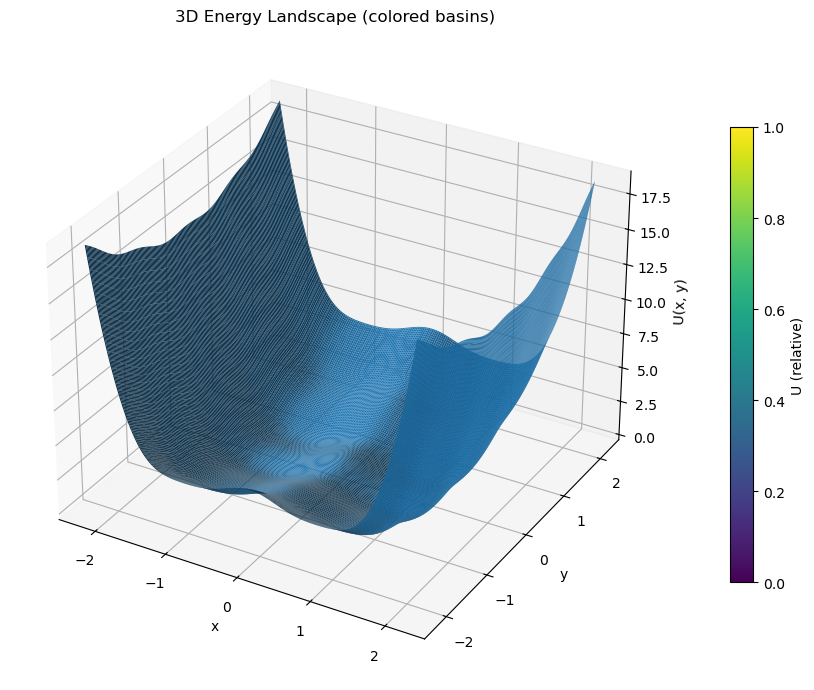

Saved: basin_3d.png


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 3D "basin" energy landscape demo (double-well / rugged)
# - Outputs a 3D surface with color-coded energy (basins)
# - Saves: basin_3d.png
# =========================================================

# Grid
n = 350
x = np.linspace(-2.2, 2.2, n)
y = np.linspace(-2.2, 2.2, n)
X, Y = np.meshgrid(x, y)

# --- A simple "W-ish" (multi-basin) potential in 2D ---
# Base double-well along x + confinement in y + small ruggedness
a = 1.0
b = 1.0
k_y = 0.8
rug_amp = 0.15
rug_k = 6.0

U = a * (X**2 - b)**2 + k_y * (Y**2)
U += rug_amp * (np.cos(rug_k * X) + np.cos(rug_k * Y))  # rugged micro-wells

# Normalize for nicer visuals (optional)
U0 = U.min()
U = U - U0

# Plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

# 3D surface with color-coded energy
surf = ax.plot_surface(X, Y, U, rstride=2, cstride=2, linewidth=0, antialiased=True)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("U(x, y)")
ax.set_title("3D Energy Landscape (colored basins)")

# Colorbar (shows energy scale)
fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.08, label="U (relative)")

plt.tight_layout()
plt.savefig("/mnt/hdd/jeff/dataset/output/collagen/ppt/basin_3d.png", dpi=200)
plt.show()

print("Saved: basin_3d.png")
